In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from datetime import datetime
from natsort import ns, natsorted

DATA_DIR = "data" # <— your real path

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 11


In [31]:
import datetime as dt

def find_samples_in_file(cha: pd.DataFrame):
    # make a copy-like behavior from your code
    cha = cha.copy()
    cha.reset_index(drop=True, inplace=True)

    # --- build time list ---
    cha_time = []
    for i in range(len(cha)):
        cha_time.append(str(cha['record_time'][i]))
    cha_time = pd.to_datetime(np.array(cha_time))
    cha_time = pd.DataFrame(cha_time)

    # compute time delta between consecutive rows
    aaa = cha_time.iloc[1:]
    aaa.reset_index(drop=True, inplace=True)
    bbb = cha_time.iloc[:-1]
    bbb.reset_index(drop=True, inplace=True)
    time_delta = (aaa - bbb)

    # your original split threshold: 10 seconds
    interval = dt.timedelta(seconds=10)

    rest_index = []
    for i in range(len(time_delta)):
        if time_delta.iloc[i, 0] > interval:
            rest_index.append(i)

    # split into charge segments
    cha_list = []
    if len(rest_index) == 0:
        cha_list = [cha]
    else:
        cha_list.append(cha.iloc[:rest_index[0]])
        for i in range(len(rest_index)-1):
            cha_cut = cha.iloc[rest_index[i]+1:rest_index[i+1]]
            cha_list.append(cha_cut)
        cha_list.append(cha.iloc[rest_index[-1]+1:])

    Ca_list = []
    cha_list_out = []
    for j in range(len(cha_list)):
        cha_cut = cha_list[j].copy()
        cha_cut.reset_index(drop=True, inplace=True)

        # your original strict filters
        if len(cha_cut) < 100:
            continue

        dif_soc = cha_cut['soc'][1:].to_numpy() - cha_cut['soc'][:-1].to_numpy()
        if np.sum(dif_soc > 2) or np.sum(dif_soc < -0.1):
            continue

        # rebuild time array
        time = []
        for i in range(len(cha_cut)):
            time.append(str(cha_cut['record_time'][i]))
        time = pd.to_datetime(np.array(time))

        current = cha_cut['charge_current'].to_numpy()
        soc = cha_cut['soc'].to_numpy()
        Tmax = np.mean(cha_cut['max_temperature'])
        Tmin = np.mean(cha_cut['min_temperature'])

        label_Ca = real_capacity_cal(time, current, soc)
        if label_Ca == 0:
            continue

        Ca_list.append([time[0], time[len(time)-1], soc[0], soc[len(soc)-1], label_Ca, Tmax, Tmin])
        cha_list_out.append(cha_cut)

    return Ca_list, cha_list_out


In [32]:
def real_capacity_cal(time_data, current, SOC_data):
    # NaN handling, same as your code
    if np.sum(np.isnan(current.tolist())) > len(current) * 0.1:
        return []
    if np.sum(np.isnan(current.tolist())):
        for n in range(len(current)):
            if np.isnan(current[n]):
                current[n] = current[n-1]

    time_sec = np.zeros(len(current))
    for j in range(len(current)):
        time_temp = time_data[j] - time_data[0]
        time_sec[j] = time_temp.total_seconds()

    # integrate current
    accumulated_Q = trapezoid(current, time_sec) / 3600 * (-1)  # Ah

    delta_SOC = SOC_data[len(SOC_data)-1] - SOC_data[0]
    if delta_SOC == 0:
        return 0

    # your formula: Q / ΔSOC * 100
    label_Ca = accumulated_Q / delta_SOC * 100
    return label_Ca


In [33]:
def load_one_vehicle(file_path: str):
    file = pd.read_csv(file_path)
    # force your column order
    file.columns = [
        'number',
        'record_time',
        'soc',
        'pack_voltage',
        'charge_current',
        'max_cell_voltage',
        'min_cell_voltage',
        'max_temperature',
        'min_temperature',
        'available_energy',
        'available_capacity'
    ]
    file = file.sort_values(by='record_time')
    file.reset_index(drop=True, inplace=True)

    Ca_list, cha_data_list = find_samples_in_file(file)
    return Ca_list, cha_data_list


In [34]:
data_list = []
dird = natsorted(os.listdir(DATA_DIR), alg=ns.PATH)

for idx, name in enumerate(dird):
    path = os.path.join(DATA_DIR, name)
    if not name.lower().endswith(".csv"):
        continue
    try:
        print(idx, "vehicle_num:", name)
        ca_list, cha_list = load_one_vehicle(path)
        data_list.append((name, ca_list, cha_list))
    except Exception as e:
        print(idx, name, "error:", e)

len(data_list)


0 vehicle_num: 1.csv
1 vehicle_num: 2.csv
2 vehicle_num: 3.csv
3 vehicle_num: 4.csv
4 vehicle_num: 5.csv
5 vehicle_num: 6.csv
6 vehicle_num: 7.csv
7 vehicle_num: 8.csv
8 vehicle_num: 9.csv
9 vehicle_num: 10.csv
10 vehicle_num: 11.csv
11 vehicle_num: 12.csv
12 vehicle_num: 13.csv
13 vehicle_num: 14.csv
14 vehicle_num: 15.csv
15 vehicle_num: 16.csv
16 vehicle_num: 17.csv
17 vehicle_num: 18.csv
18 vehicle_num: 19.csv
19 vehicle_num: 20.csv


20

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

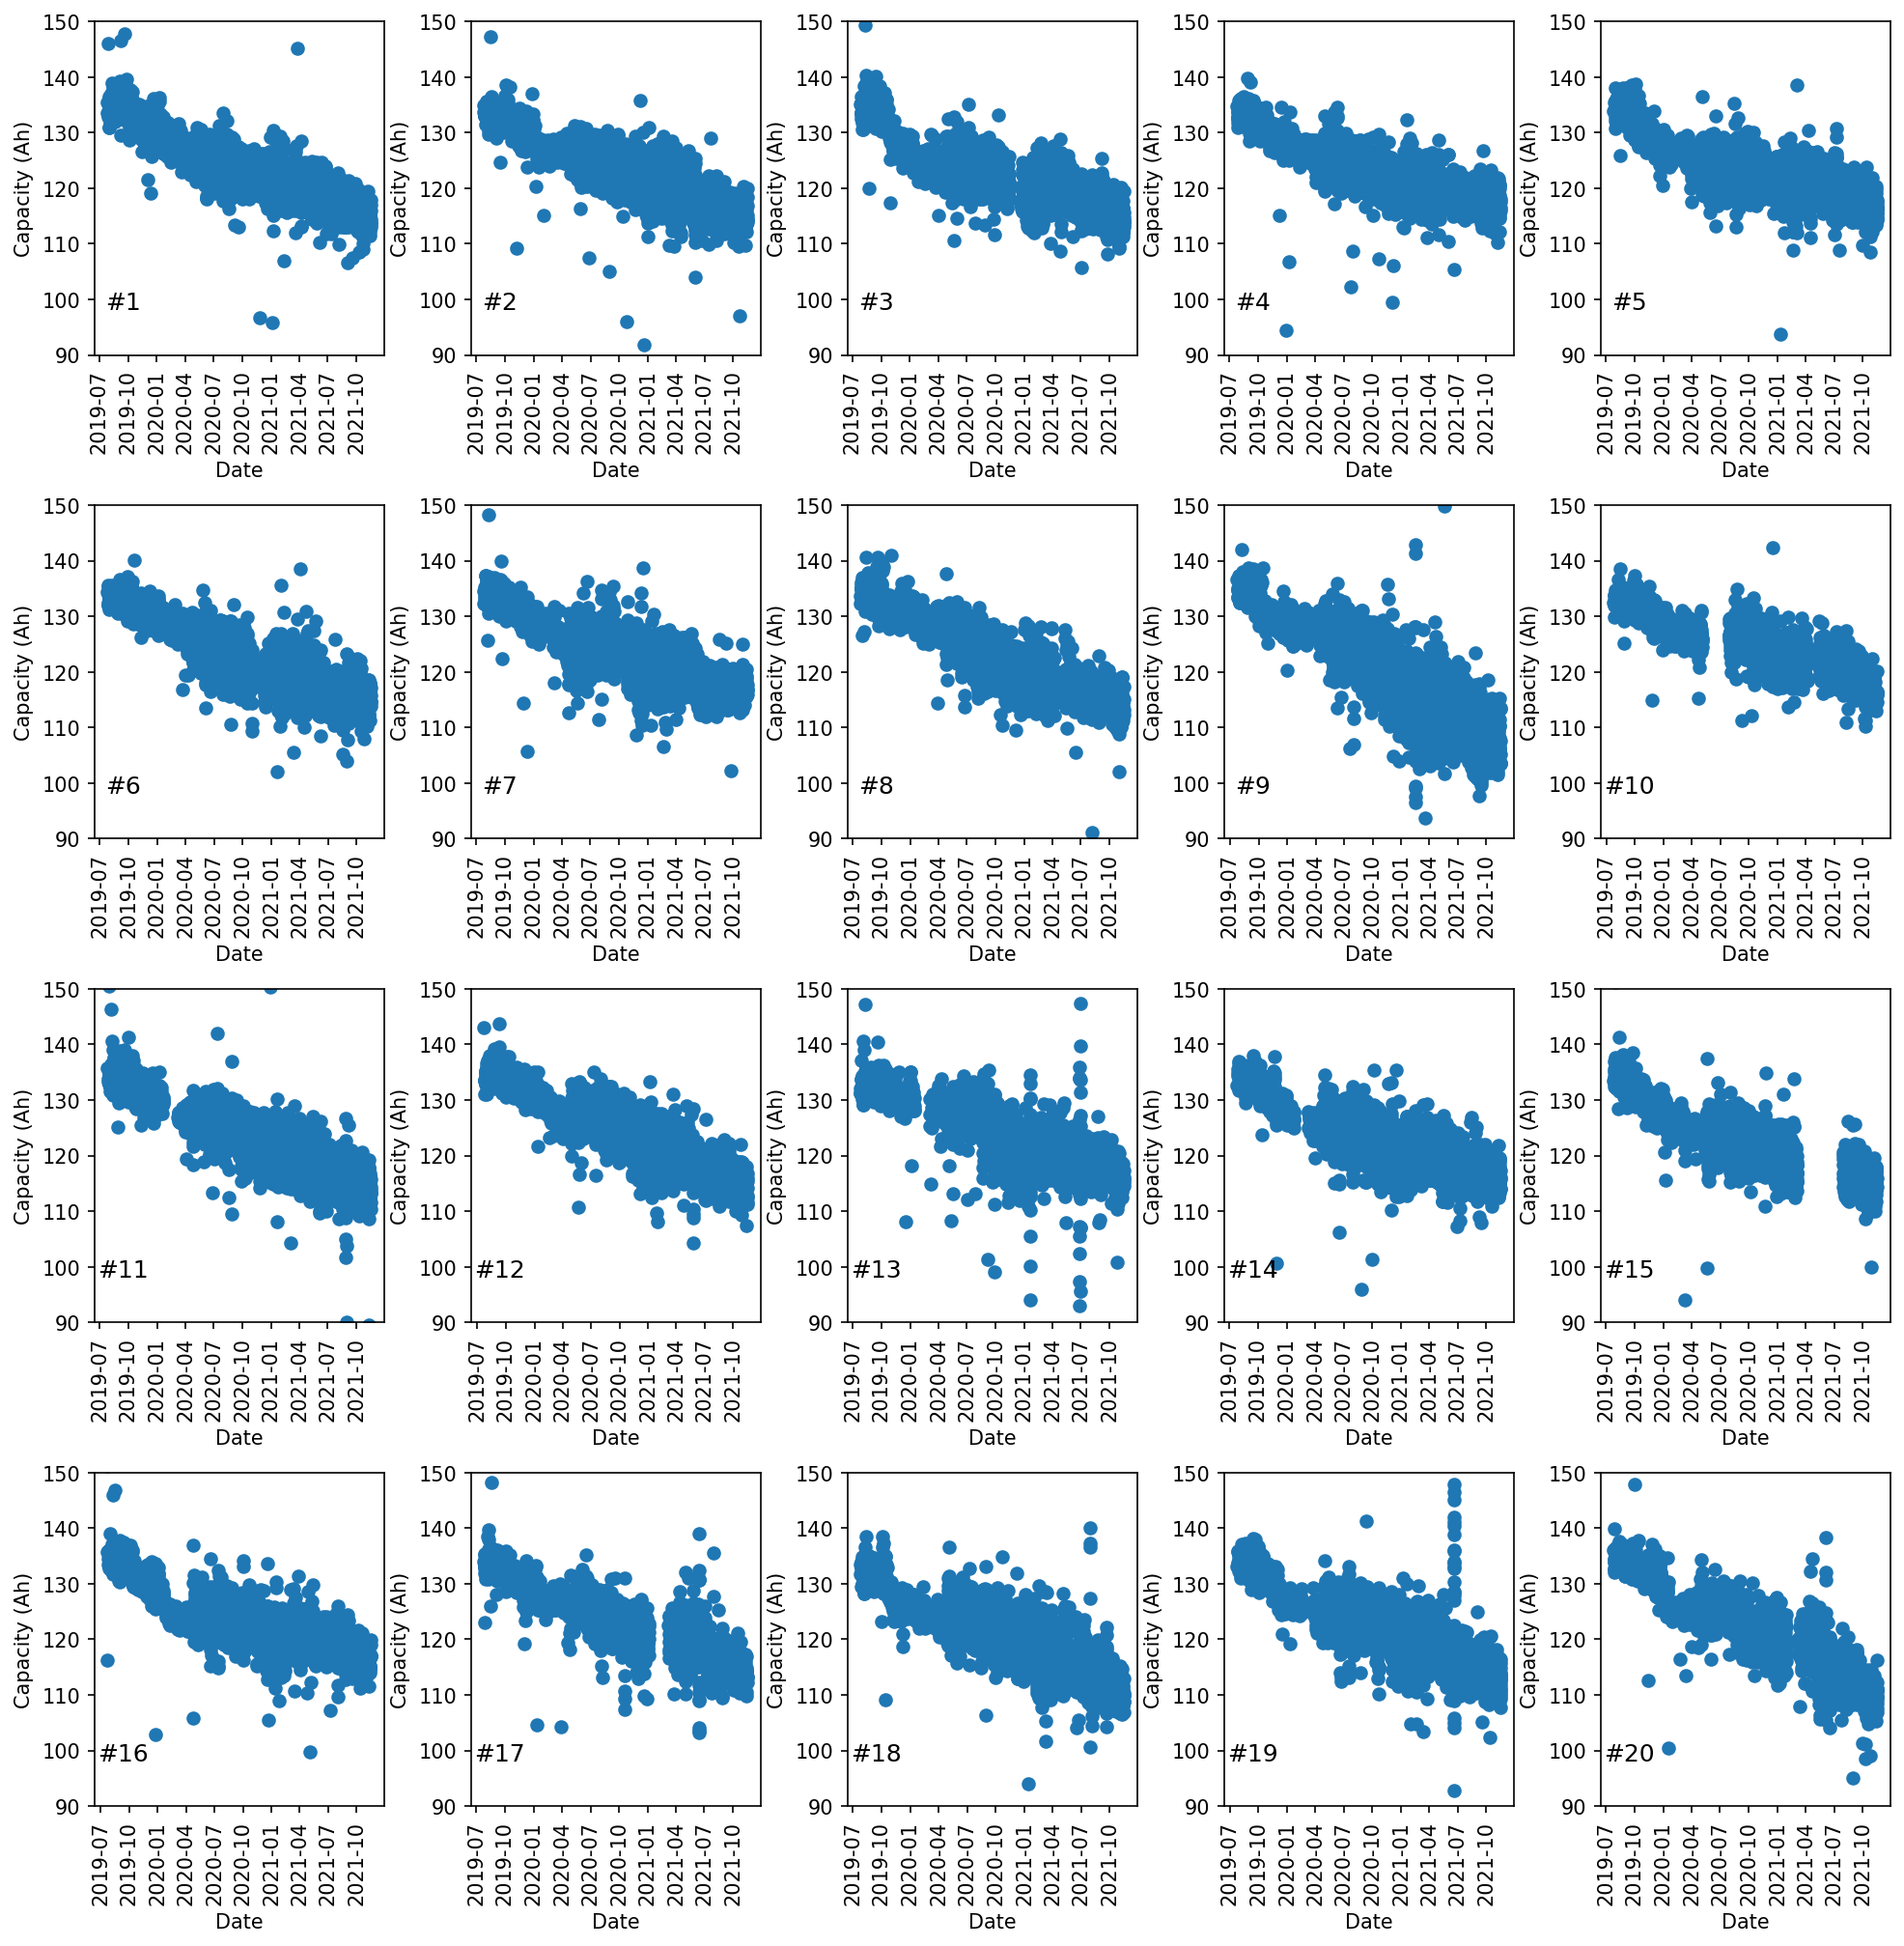

In [35]:
from matplotlib import rcParams
rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 10,
})

plt.figure(figsize=(16, 16), dpi=150)
plt.subplots_adjust(wspace=0.30, hspace=0.45)

for j, (veh_name, ca_list, cha_list) in enumerate(data_list):
    veh_df = pd.DataFrame(
        data=ca_list,
        columns=['time_s','time_e','SOC_s','SOC_e','charge_capacity','Tmax','Tmin']
    )

    plt.subplot(4, 5, j+1)
    if not veh_df.empty:
        plt.plot(veh_df["time_s"], veh_df["charge_capacity"], 'o')
    plt.ylabel('Capacity (Ah)')
    plt.xlabel('Date')
    plt.ylim([90, 150])
    plt.title('#' + str(j+1), x=0.1, y=0.1)
    plt.xticks(rotation=90)

plt.show()


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

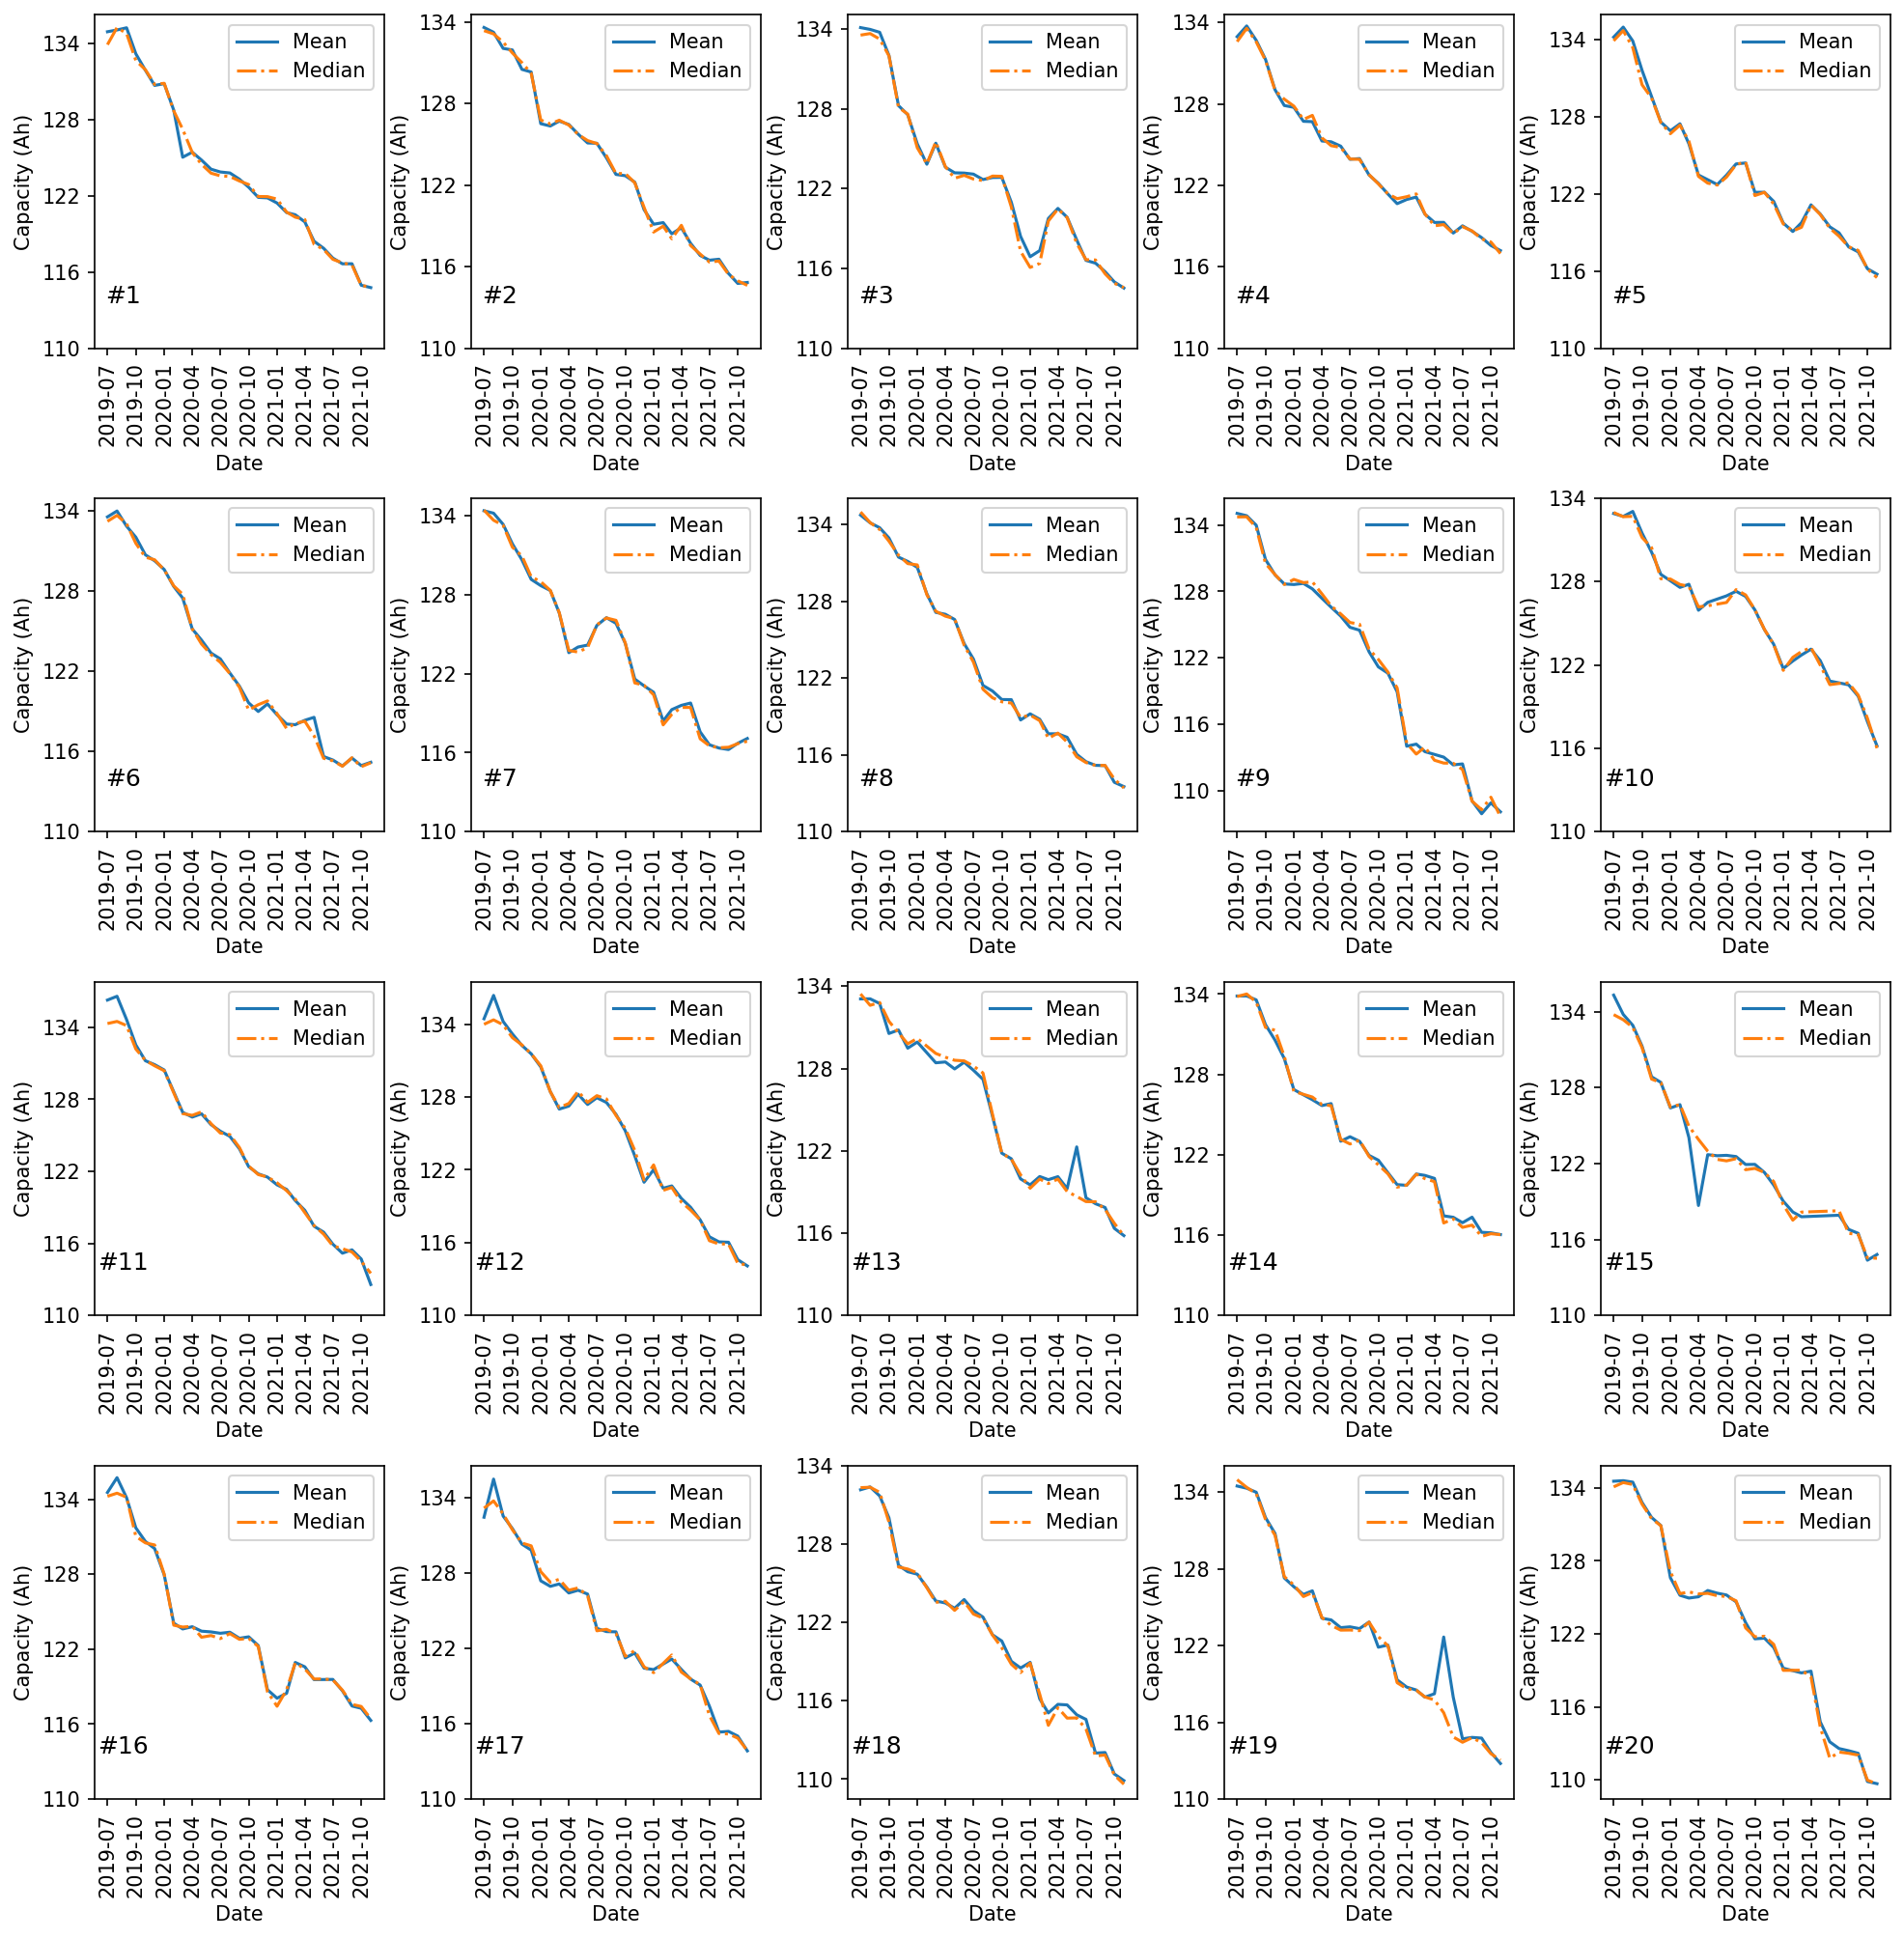

In [36]:
plt.figure(figsize=(16, 16), dpi=150)
plt.subplots_adjust(wspace=0.30, hspace=0.45)

for j, (veh_name, ca_list, cha_list) in enumerate(data_list):
    veh_df = pd.DataFrame(
        data=ca_list,
        columns=['time_s','time_e','SOC_s','SOC_e','charge_capacity','Tmax','Tmin']
    )
    if veh_df.empty:
        continue

    veh_df.reset_index(drop=True, inplace=True)
    # group by month based on time_e
    veh_df["month"] = veh_df["time_e"].dt.to_period("M").dt.to_timestamp()

    ca_month = veh_df.groupby("month")["charge_capacity"].apply(list)

    time_index = list(ca_month.index)
    veh_ca_mean = [np.mean(x) for x in ca_month]
    veh_ca_median = [np.median(x) for x in ca_month]

    plt.subplot(4, 5, j+1)
    plt.plot(time_index, veh_ca_mean)
    plt.plot(time_index, veh_ca_median, '-.')
    plt.title('#' + str(j+1), x=0.1, y=0.1)
    plt.xticks(rotation=90)
    plt.yticks(np.arange(110, 135, 6))
    plt.ylabel('Capacity (Ah)')
    plt.xlabel('Date')
    plt.legend(['Mean','Median'], loc=1)

plt.show()


Total charge sessions extracted: 53926


,vehicle,veh_name,time_s,time_e,soc_s,soc_e,delta_soc,charge_capacity,tmax,tmin
0,1,1.csv,2019-07-26 20:02:35,2019-07-26 22:05:25,27.2,99.6,72.4,133.556559,43.291441,40.821235
1,1,1.csv,2019-07-27 04:06:56,2019-07-27 05:47:08,30.0,99.6,69.6,135.444164,42.271277,38.839096
2,1,1.csv,2019-07-28 17:25:00,2019-07-28 18:21:11,39.6,88.8,49.2,133.516035,37.881517,36.874408
3,1,1.csv,2019-07-28 18:21:55,2019-07-28 18:54:06,89.2,99.6,10.4,145.949787,39.102881,38.000000
4,1,1.csv,2019-07-29 12:53:17,2019-07-29 14:39:05,26.8,86.0,59.2,133.690123,38.464736,37.055416


=== Global Pearson (all vehicles) ===


,feature,pearson
1,soc_e,0.326103
2,delta_soc,0.277359
0,soc_s,0.042862
3,tmax,0.036051
4,tmin,0.030832


=== Global Grey Relational Grade (all vehicles) ===


,feature,GRG
2,delta_soc,0.795836
0,soc_s,0.569844
4,tmin,0.504451
3,tmax,0.494158
1,soc_e,0.440371


=== Per-vehicle Pearson matrix ===


,soc_s,soc_e,delta_soc,tmax,tmin
vehicle,,,,,
1,-0.034600,0.345421,0.370359,-0.049086,-0.054293
2,0.016253,0.338340,0.309920,0.024989,0.021409
3,0.027219,0.402726,0.364764,0.056234,0.050361
4,-0.028173,0.330059,0.360623,0.037940,0.029237
5,0.041141,0.375130,0.337649,0.089615,0.084557
6,0.033424,0.444793,0.398664,-0.005452,-0.014498
7,0.022837,0.345433,0.320878,0.049002,0.040919
8,0.018460,0.389809,0.371373,-0.003419,-0.005303
9,0.215902,0.496834,0.284175,0.121729,0.108320


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

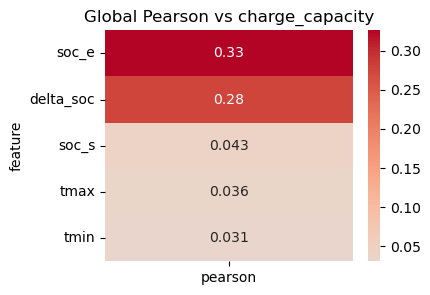

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

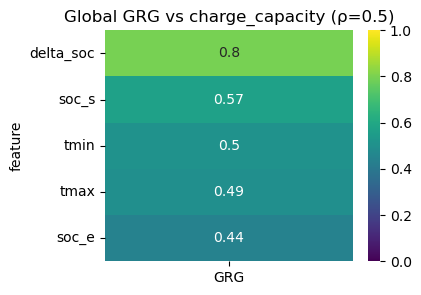

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

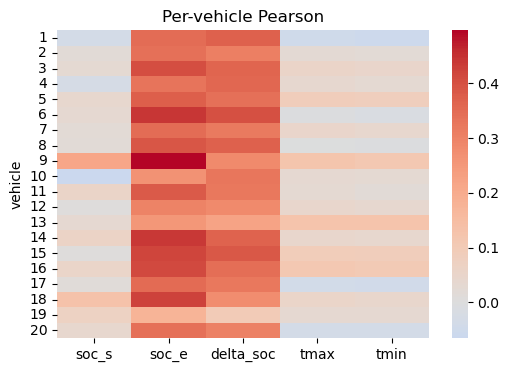

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1) Build one big DataFrame from your extracted data_list
rows = []
for vid, (veh_name, ca_list, cha_list) in enumerate(data_list, start=1):
    # ca_list is a list of [time_s, time_e, SOC_s, SOC_e, charge_capacity, Tmax, Tmin]
    for rec in ca_list:
        time_s, time_e, soc_s, soc_e, cap, tmax, tmin = rec
        rows.append({
            "vehicle": vid,
            "veh_name": veh_name,
            "time_s": time_s,
            "time_e": time_e,
            "soc_s": soc_s,
            "soc_e": soc_e,
            "delta_soc": soc_e - soc_s,
            "charge_capacity": cap,
            "tmax": tmax,
            "tmin": tmin,
        })

sessions_df = pd.DataFrame(rows)
print("Total charge sessions extracted:", len(sessions_df))
display(sessions_df.head())

# add month (for later, maybe)
sessions_df["month"] = sessions_df["time_e"].dt.to_period("M").dt.to_timestamp()

# 2) Define features to test (based on what you actually have)
FEATURES = [
    "soc_s",
    "soc_e",
    "delta_soc",
    "tmax",
    "tmin",
]

target = "charge_capacity"

# 3) --- GLOBAL PEARSON (all vehicles pooled) ---
global_pcc = []
for f in FEATURES:
    x = sessions_df[f].values
    y = sessions_df[target].values
    # drop NaNs pairwise
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 2:
        r = np.nan
    else:
        r, _ = pearsonr(x[mask], y[mask])
    global_pcc.append({"feature": f, "pearson": r})

global_pcc_df = pd.DataFrame(global_pcc).sort_values("pearson", ascending=False)
print("=== Global Pearson (all vehicles) ===")
display(global_pcc_df)

# 4) --- GLOBAL GREY RELATIONAL GRADE (all vehicles pooled) ---
def grey_relational_grade(y: np.ndarray, x: np.ndarray, rho=0.5) -> float:
    # normalize to [0,1]
    def norm(a):
        a = np.asarray(a, dtype=float)
        amin, amax = np.min(a), np.max(a)
        return (a - amin) / (amax - amin + 1e-12)
    y0 = norm(y)
    x0 = norm(x)
    diff = np.abs(y0 - x0)
    dmin, dmax = diff.min(), diff.max()
    xi = (dmin + rho * dmax) / (diff + rho * dmax + 1e-12)
    return float(xi.mean())

global_grg = []
for f in FEATURES:
    x = sessions_df[f].values
    y = sessions_df[target].values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 2:
        grg = np.nan
    else:
        grg = grey_relational_grade(y[mask], x[mask], rho=0.5)
    global_grg.append({"feature": f, "GRG": grg})

global_grg_df = pd.DataFrame(global_grg).sort_values("GRG", ascending=False)
print("=== Global Grey Relational Grade (all vehicles) ===")
display(global_grg_df)

# 5) --- PER-VEHICLE PCC (for heatmap) ---
perveh_rows = []
for vid, dfv in sessions_df.groupby("vehicle"):
    y = dfv[target].values
    if len(y) < 2:
        # can't correlate with only 1 point
        continue
    row = {"vehicle": vid}
    for f in FEATURES:
        x = dfv[f].values
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() < 2:
            r = np.nan
        else:
            r, _ = pearsonr(x[mask], y[mask])
        row[f] = r
    perveh_rows.append(row)

perveh_df = pd.DataFrame(perveh_rows).set_index("vehicle")
print("=== Per-vehicle Pearson matrix ===")
display(perveh_df)

# 6) --- Heatmaps ---
# Global barplot-like heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(global_pcc_df.set_index("feature")[["pearson"]], annot=True, cmap="coolwarm", center=0)
plt.title("Global Pearson vs charge_capacity")
plt.show()

plt.figure(figsize=(4, 3))
sns.heatmap(global_grg_df.set_index("feature")[["GRG"]], annot=True, cmap="viridis", vmin=0, vmax=1)
plt.title("Global GRG vs charge_capacity (ρ=0.5)")
plt.show()

# Per-vehicle heatmap (only if we have enough vehicles with ≥2 sessions)
if not perveh_df.empty:
    plt.figure(figsize=(6, 4))
    sns.heatmap(perveh_df[FEATURES], cmap="coolwarm", center=0)
    plt.title("Per-vehicle Pearson")
    plt.show()
else:
    print("Not enough vehicles with >= 2 sessions to make per-vehicle heatmap.")


In [ ]:
import pandas as pd
import numpy as np
def find_charge_sessions(df: pd.DataFrame,
                         min_soc_increase=1.0,   # relaxed from 5.0%
                         min_points=3,           # relaxed from 10 points
                         current_thresh=-0.3):   # relaxed from -1.0 A
    """
    Identify charging sessions in the dataset.

    Returns list of (start_idx, end_idx) inclusive for charge sessions that
    have SOC increase >= min_soc_increase and at least min_points samples.
    This relaxed version ensures more charge sessions get detected.
    """
    c = df["current"].values
    soc = df["soc"].values
    sessions = []
    n = len(df)

    i = 0
    while i < n - 1:
        # start when current goes below threshold
        if c[i] < current_thresh:
            start = i
            # continue while still charging OR small interruptions
            while i < n - 1 and (
                c[i] < current_thresh or
                (df["time"].iloc[i + 1] - df["time"].iloc[i]).total_seconds() <= 2 * df.attrs["dt_sec"]
            ):
                i += 1
            end = i
            if end > start:
                soc_inc = soc[end] - soc[start]
                if soc_inc >= min_soc_increase and (end - start + 1) >= min_points:
                    sessions.append((start, end))
        i += 1

    return sessions


def capacity_from_session(df: pd.DataFrame, start: int, end: int) -> float:
    """
    Estimate capacity using Ampere integral method:
        Ca = -(Σ I * Δt) / (SOC_end - SOC_start)
    SOC in %, convert to fraction.
    Returns capacity in Ah (assuming current in A).
    """
    dt = df.attrs["dt_sec"]
    I = df.loc[start:end, "current"].values
    dQ = np.sum(I * dt)  # A·s
    soc1, soc2 = df.loc[start, "soc"] / 100.0, df.loc[end, "soc"] / 100.0
    dSOC = soc2 - soc1
    if dSOC <= 1e-6:
        return np.nan
    Ca_As = -dQ / dSOC  # A·s
    Ca_Ah = Ca_As / 3600.0  # convert to Ah
    return Ca_Ah


def monthly_capacity_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute capacity for each valid charge session,
    then aggregate by month using median & mean.
    Returns DataFrame with month, cap_median, cap_mean, and count.
    """
    sessions = find_charge_sessions(df)
    if not sessions:
        return pd.DataFrame(columns=["month", "cap_median", "cap_mean", "count"])

    rows = []
    for s, e in sessions:
        cap = capacity_from_session(df, s, e)
        when = df.loc[e, "time"]  # use end of session as timestamp
        if pd.notnull(cap):
            rows.append({"time": when, "cap": cap})

    if not rows:
        return pd.DataFrame(columns=["month", "cap_median", "cap_mean", "count"])

    sess = pd.DataFrame(rows)
    sess["month"] = sess["time"].dt.to_period("M").dt.to_timestamp()

    out = sess.groupby("month").agg(
        cap_median=("cap", "median"),
        cap_mean=("cap", "mean"),
        count=("cap", "size")
    ).reset_index()

    return out


# --- Quick test on vehicle #1 ---
import pandas as pd

labels_1 = monthly_capacity_labels(df1)
print("Valid charge sessions extracted:", len(labels_1))
display(labels_1.head())


ValueError: Missing column provided to 'parse_dates': 'time'

Combined data shape: (16100728, 12)


,number,record_time,soc,pack_voltage,charge_current,max_cell_voltage,min_cell_voltage,max_temperature,min_temperature,available_energy,available_capacity,vehicle
0,0,20190726200235,27.2,328.2,-52.20001,3.656,3.640,41,38,12.40,37.28,1
1,1,20190726200243,27.6,328.5,-52.20001,3.663,3.645,41,38,12.44,37.39,1
2,2,20190726200251,27.6,328.6,-52.20001,3.665,3.647,41,38,12.47,37.51,1
3,3,20190726200259,27.6,328.6,-52.20001,3.666,3.649,41,38,12.52,37.64,1
4,4,20190726200307,27.6,328.8,-52.20001,3.666,3.649,41,38,12.56,37.76,1


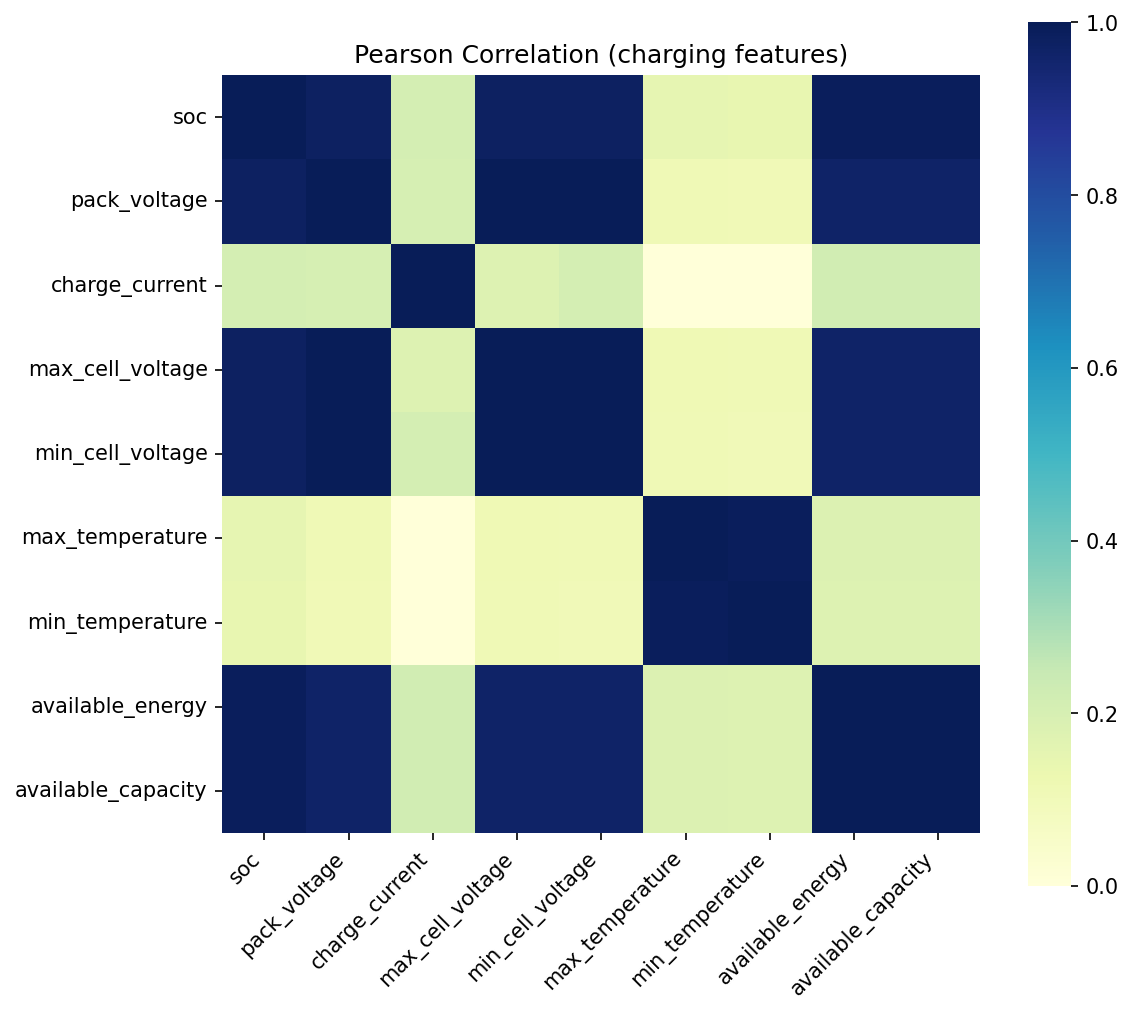

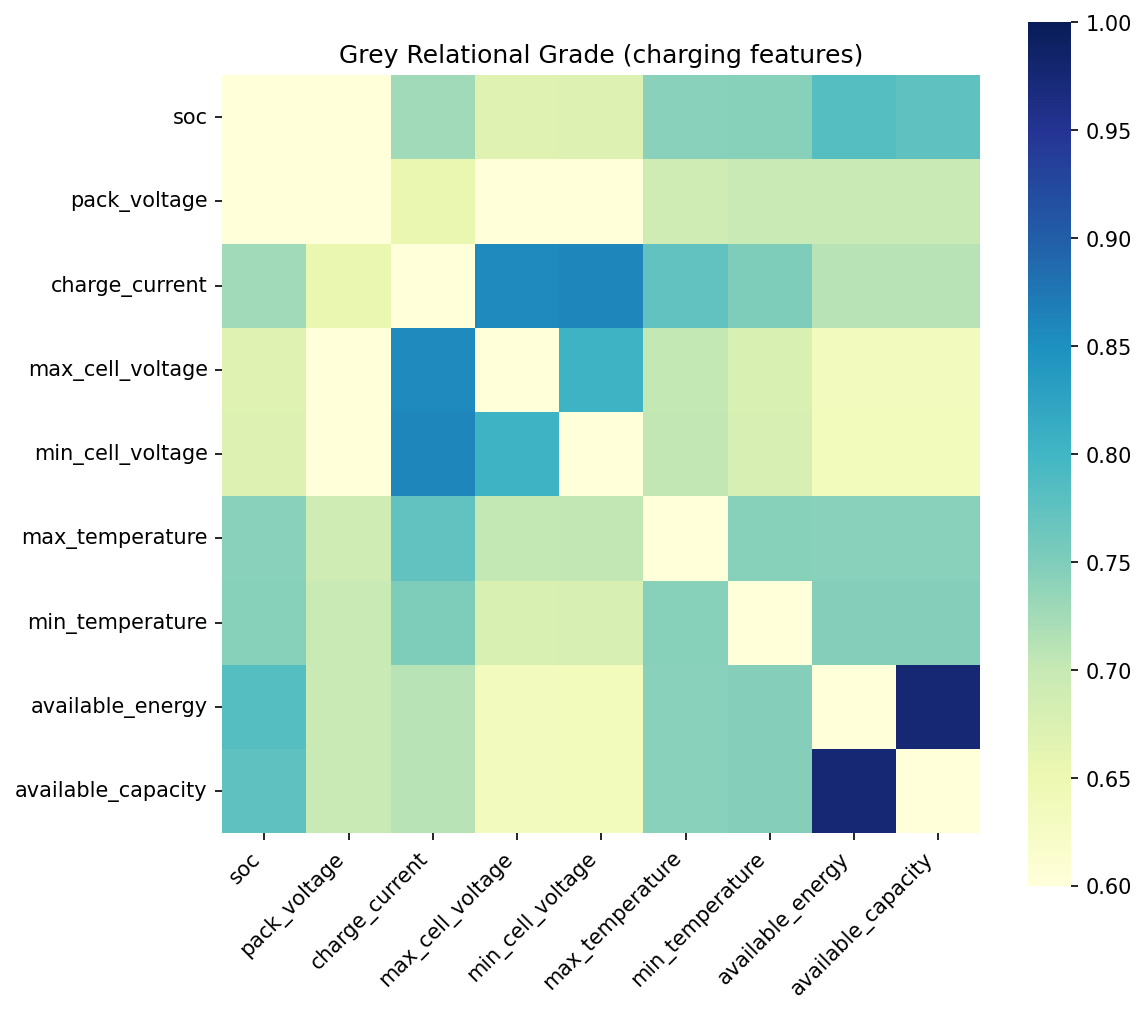

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import glob, os

DATA_DIR = "data"  # or "/home/kafkayasha/gpr_model/data"

# 1. Load all CSVs and concatenate into one big DataFrame
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
dfs = []
for i, f in enumerate(all_files, start=1):
    df = pd.read_csv(f)
    df.columns = ['number','record_time','soc','pack_voltage','charge_current',
                  'max_cell_voltage','min_cell_voltage','max_temperature',
                  'min_temperature','available_energy','available_capacity']
    df["vehicle"] = i
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
print("Combined data shape:", data.shape)
display(data.head())

# 2. Select only numeric columns
num_cols = [
    "soc", "pack_voltage", "charge_current",
    "max_cell_voltage", "min_cell_voltage",
    "max_temperature", "min_temperature",
    "available_energy", "available_capacity"
]

numeric_df = data[num_cols].dropna()

# 3. Pearson correlation (like Fig. 4a)
pearson_corr = numeric_df.corr(method="pearson")

plt.figure(figsize=(8,8), dpi=150)
sns.heatmap(pearson_corr, cmap="YlGnBu", vmin=0, vmax=1, square=True,
            cbar_kws={"shrink":0.8})
plt.title("Pearson Correlation (charging features)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Grey Relational Grade (like Fig. 4b)
def grey_relational_grade_seq(y: np.ndarray, x: np.ndarray, rho=0.5) -> float:
    def norm(a):
        a = np.asarray(a, dtype=float)
        amin, amax = np.min(a), np.max(a)
        return (a - amin) / (amax - amin + 1e-12)
    y0, x0 = norm(y), norm(x)
    diff = np.abs(y0 - x0)
    dmin, dmax = diff.min(), diff.max()
    xi = (dmin + rho*dmax) / (diff + rho*dmax + 1e-12)
    return float(xi.mean())

cols = num_cols
grg_mat = pd.DataFrame(index=cols, columns=cols, dtype=float)

for i in cols:
    for j in cols:
        xi, xj = numeric_df[i].values, numeric_df[j].values
        mask = np.isfinite(xi) & np.isfinite(xj)
        if mask.sum() < 2:
            grg = np.nan
        else:
            grg = grey_relational_grade_seq(xi[mask], xj[mask], rho=0.5)
        grg_mat.loc[i,j] = grg

plt.figure(figsize=(8,8), dpi=150)
sns.heatmap(grg_mat.astype(float), cmap="YlGnBu", vmin=0.6, vmax=1.0, square=True,
            cbar_kws={"shrink":0.8})
plt.title("Grey Relational Grade (charging features)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Parsed time range: 2019-07-26 20:02:35 → 2021-11-15 16:46:40
Median Δt (s): 8.0
[veh 1] segments kept after strict+fallback: 2790
[veh 1] months with Ca: 29
Feature rows (veh 1): 29


,month_ts,Month,Ca,I_ave,I_sum,I_std,Vpack_ave,Vpack_sum,Vpack_std,SOC_ave,...,Tmax_std,Tmin_ave,Tmin_sum,Tmin_std,Vd_ave,Vd_sum,Vd_std,Td_ave,Td_sum,Td_std
0,2019-07-01,7,133.891234,-42.449116,-3.559358e+05,19.098846,350.283506,2937127.2,17.392414,62.507621,...,2.979577,35.809660,300264.0,3.063319,0.018809,157.711,0.005941,2.398688,20113.0,0.799537
1,2019-08-01,8,135.236125,-45.604135,-1.862792e+06,20.213760,354.099373,14463897.1,18.045048,66.491640,...,3.631516,36.047690,1472440.0,3.573147,0.020339,830.777,0.006128,2.059980,84144.0,0.736439
2,2019-09-01,9,134.771645,-47.886329,-2.081331e+06,20.675622,355.745421,15462119.0,17.841221,68.653957,...,3.250117,36.163998,1571832.0,3.217373,0.021860,950.138,0.006154,2.152448,93554.0,0.771851
3,2019-10-01,10,132.645147,-50.642029,-2.366249e+06,16.999746,352.335283,16462866.1,16.401280,64.409383,...,2.523276,33.990519,1588207.0,2.490606,0.023082,1078.520,0.005514,2.229192,104159.0,0.759412
4,2019-11-01,11,131.917019,-49.574537,-2.041182e+06,13.549153,348.659773,14355717.5,15.760074,58.855365,...,3.524553,29.740346,1224529.0,3.407733,0.022877,941.937,0.005067,1.923593,79202.0,0.766579


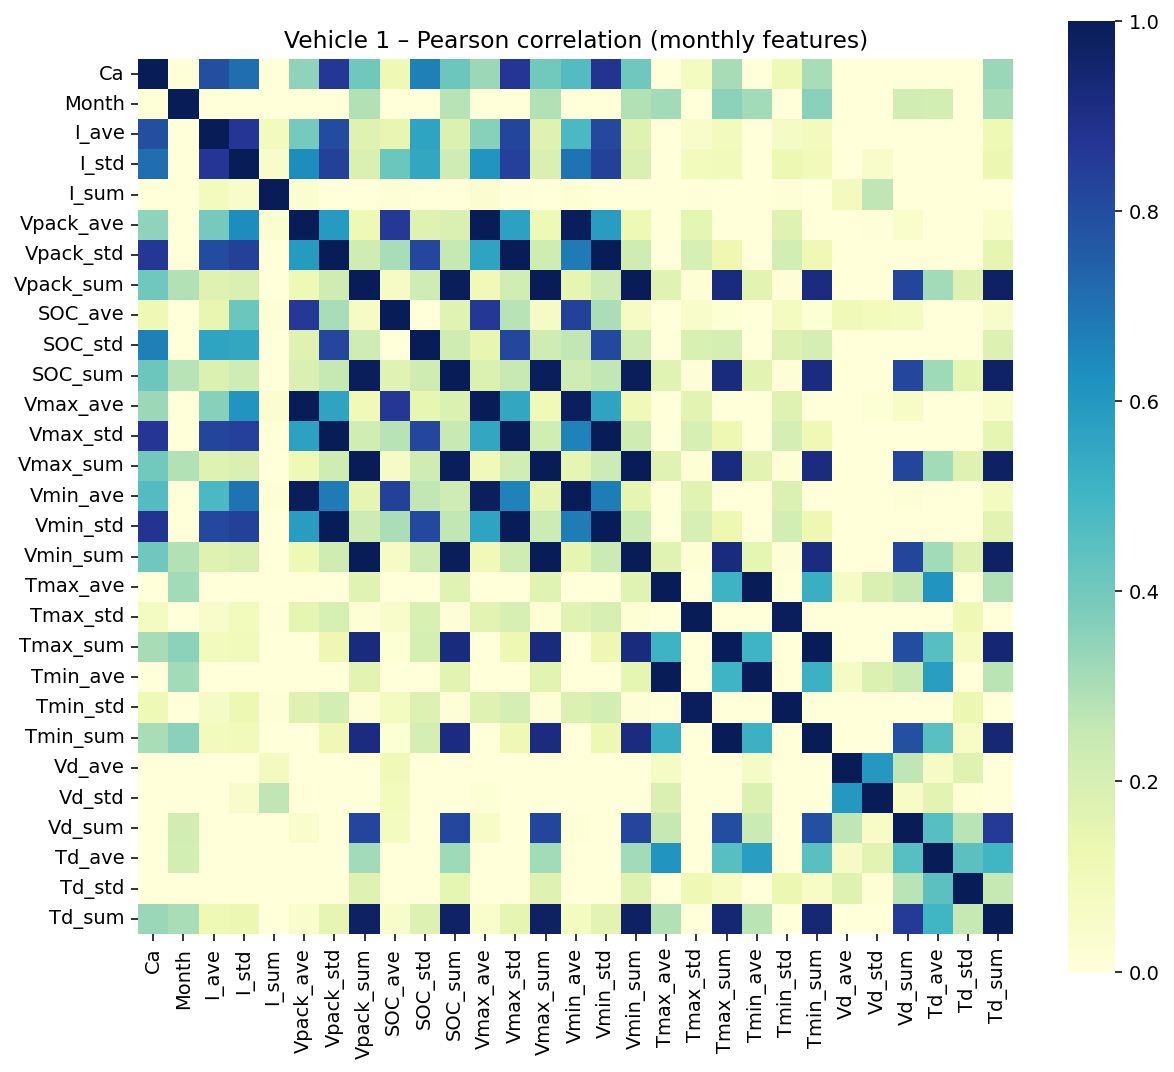

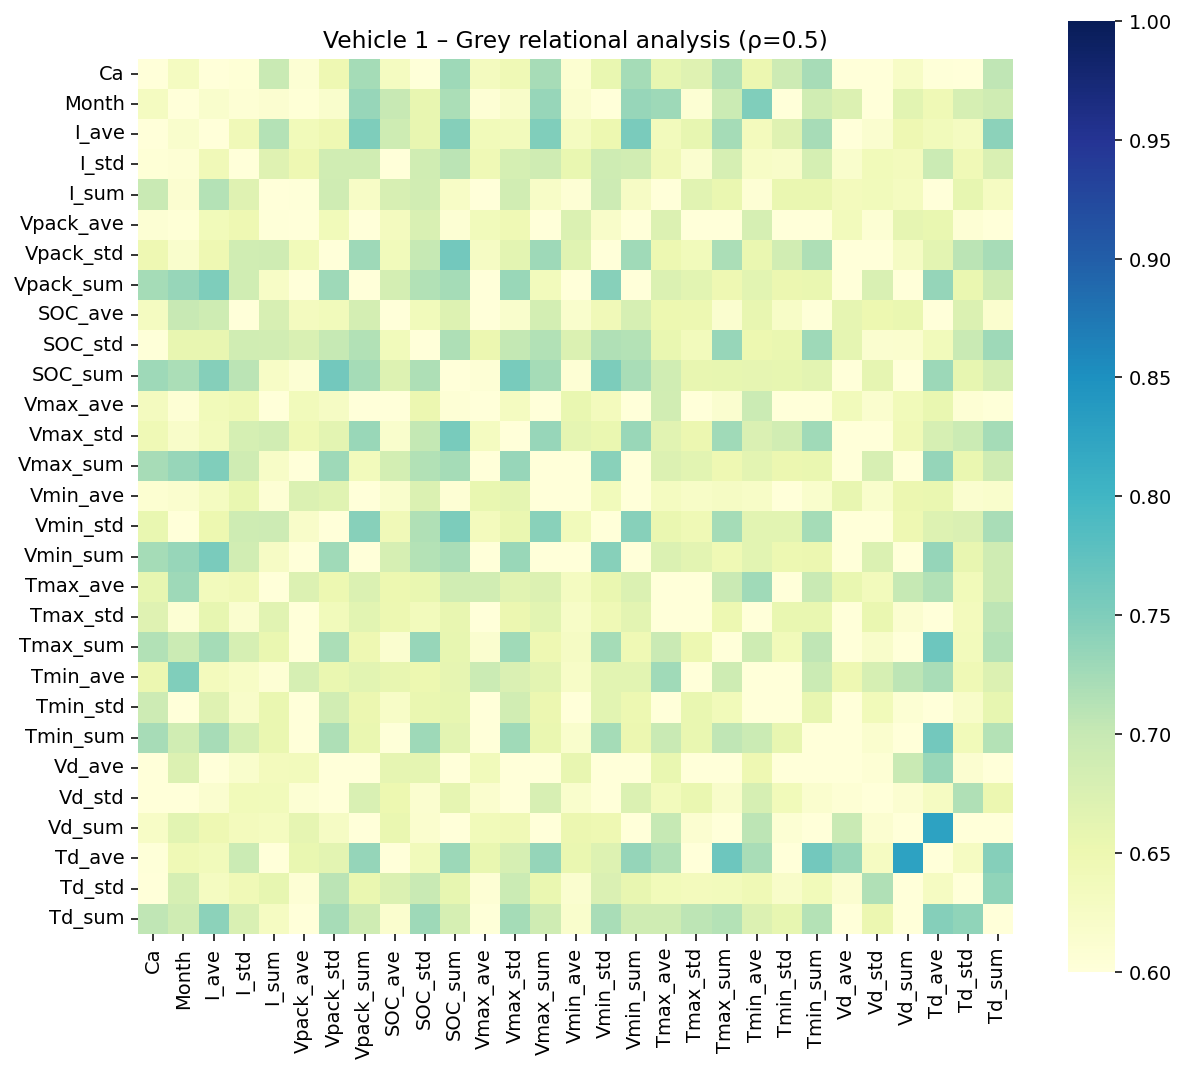

In [5]:
# === Vehicle 1: correct timestamp parsing + strict sessions + Pearson & GRG heatmaps ===
import os, re, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import datetime as dt
from scipy.integrate import trapezoid

VEHICLE_FILE = "data/1.csv"    # adjust path if needed

# strict rules (your originals)
GAP_SECONDS     = 10
SESSION_MIN_LEN = 100
SOC_JUMP_POS    = 2.0
SOC_JUMP_NEG    = -0.1
GRG_RHO         = 0.5
CHARGE_I_THRESH = -0.5   # fallback: consider charging when I < -0.5 A
MAX_MERGE_GAPS  = 2      # allow merges up to 2*dt

def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # drop stray "Unnamed" columns
    for c in list(df.columns):
        if str(c).lower().startswith("unnamed"):
            df = df.drop(columns=[c])

    # normalize headers (strip units)
    ren = {c: re.sub(r"\s*\(.*?\)\s*", "", str(c)).strip().lower() for c in df.columns}
    df = df.rename(columns=ren)

    need = ["record_time","soc","pack_voltage","charge_current",
            "max_cell_voltage","min_cell_voltage","max_temperature","min_temperature",
            "available_energy","available_capacity"]
    miss = [n for n in need if n not in df.columns]
    if miss:
        raise ValueError(f"Missing columns {miss} in {os.path.basename(path)}")

    # --- CRITICAL FIX: parse YYYYMMDDhhmmss explicitly ---
    rt_raw = df["record_time"].astype(str)
    # grab first 14 consecutive digits if present
    rt14 = rt_raw.str.extract(r"(\d{14})", expand=False)
    parsed = pd.to_datetime(rt14, format="%Y%m%d%H%M%S", errors="coerce")
    # fallback for any rows that didn't match 14 digits
    fallback_mask = parsed.isna()
    if fallback_mask.any():
        parsed.loc[fallback_mask] = pd.to_datetime(rt_raw.loc[fallback_mask], errors="coerce")
    df["record_time"] = parsed

    # numeric types
    for c in ["soc","pack_voltage","charge_current","max_cell_voltage","min_cell_voltage",
              "max_temperature","min_temperature","available_energy","available_capacity"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["record_time"]).sort_values("record_time").reset_index(drop=True)

    # derived channels (paper)
    df["I"]     = df["charge_current"]
    df["Vpack"] = df["pack_voltage"]
    df["SOC"]   = df["soc"]
    df["Vmax"]  = df["max_cell_voltage"]
    df["Vmin"]  = df["min_cell_voltage"]
    df["Tmax"]  = df["max_temperature"]
    df["Tmin"]  = df["min_temperature"]
    df["Vd"]    = (df["Vmax"] - df["Vmin"]).abs()
    df["Td"]    = (df["Tmax"] - df["Tmin"]).abs()
    return df

def median_dt_seconds(df: pd.DataFrame) -> float:
    d = df["record_time"].diff().dt.total_seconds().dropna()
    return float(np.median(d)) if len(d) else 1.0

def split_by_time_gaps(df: pd.DataFrame):
    t = pd.DataFrame(df["record_time"])
    aaa = t.iloc[1:].reset_index(drop=True)
    bbb = t.iloc[:-1].reset_index(drop=True)
    dts = (aaa - bbb)
    gap = dt.timedelta(seconds=GAP_SECONDS)
    cut = [i for i in range(len(dts)) if dts.iloc[i,0] > gap]
    segs = []
    if not cut:
        segs = [df]
    else:
        segs.append(df.iloc[:cut[0]])
        for i in range(len(cut)-1):
            segs.append(df.iloc[cut[i]+1:cut[i+1]])
        segs.append(df.iloc[cut[-1]+1:])
    return [s.reset_index(drop=True) for s in segs]

def strict_keep(seg: pd.DataFrame) -> bool:
    if len(seg) < SESSION_MIN_LEN:
        return False
    dif_soc = seg["SOC"].iloc[1:].to_numpy() - seg["SOC"].iloc[:-1].to_numpy()
    if np.sum(dif_soc > SOC_JUMP_POS) or np.sum(dif_soc < SOC_JUMP_NEG):
        return False
    return True

def split_by_current(df: pd.DataFrame, dt_sec: float):
    """Fallback: contiguous blocks where I < CHARGE_I_THRESH; merge tiny breaks up to 2*dt."""
    mask = df["I"].to_numpy() < CHARGE_I_THRESH
    segs = []
    start = None
    for i, on in enumerate(mask):
        if on and start is None:
            start = i
        if (not on or i == len(mask)-1) and start is not None:
            end = i if not on else i
            segs.append(df.iloc[start:end+1].copy().reset_index(drop=True))
            start = None
    merged = []
    for s in segs:
        if not merged:
            merged.append(s); continue
        last = merged[-1]
        gap = (s["record_time"].iloc[0] - last["record_time"].iloc[-1]).total_seconds()
        if gap <= MAX_MERGE_GAPS * dt_sec:
            merged[-1] = pd.concat([last, s], ignore_index=True)
        else:
            merged.append(s)
    return merged

def capacity_from_segment(seg: pd.DataFrame):
    cur = seg["I"].to_numpy(dtype=float)
    if np.isnan(cur).mean() > 0.1:
        return None
    if np.isnan(cur).any():
        for i in range(1, len(cur)):
            if np.isnan(cur[i]):
                cur[i] = cur[i-1]
    t = pd.to_datetime(seg["record_time"]).to_numpy()
    t0 = t[0]
    secs = np.array([(ti - t0).astype("timedelta64[s]").astype(float) for ti in t], dtype=float)
    Ah = trapezoid(cur, secs)/3600.0 * (-1.0)
    dSOC = float(seg["SOC"].iloc[-1] - seg["SOC"].iloc[0])
    if abs(dSOC) < 1e-9:
        return None
    return Ah / dSOC * 100.0

def add_stats(row, prefix, series):
    x = series.to_numpy(dtype=float)
    row[f"{prefix}_ave"] = float(np.nanmean(x)) if len(x) else np.nan
    row[f"{prefix}_sum"] = float(np.nansum(x)) if len(x) else np.nan
    row[f"{prefix}_std"] = float(np.nanstd(x, ddof=0)) if len(x) else np.nan

def grey_relational_grade_seq(y: np.ndarray, x: np.ndarray, rho=GRG_RHO) -> float:
    def norm(a):
        a = np.asarray(a, dtype=float)
        amin, amax = np.nanmin(a), np.nanmax(a)
        return (a - amin) / (amax - amin + 1e-12)
    y0, x0 = norm(y), norm(x)
    diff = np.abs(y0 - x0)
    dmin, dmax = np.nanmin(diff), np.nanmax(diff)
    xi = (dmin + rho*dmax) / (diff + rho*dmax + 1e-12)
    return float(np.nanmean(xi))

# ---------- run for vehicle 1 ----------
df1 = load_csv(VEHICLE_FILE)
print("Parsed time range:", df1["record_time"].min(), "→", df1["record_time"].max())
print("Median Δt (s):", median_dt_seconds(df1))

dt_sec = median_dt_seconds(df1)
segs = [s for s in split_by_time_gaps(df1) if strict_keep(s)]
if not segs:
    segs = [s for s in split_by_current(df1, dt_sec) if strict_keep(s)]
print(f"[veh 1] segments kept after strict+fallback:", len(segs))

# Ca per session -> monthly median
ca_recs = []
for seg in segs:
    Ca = capacity_from_segment(seg)
    if Ca is None:
        continue
    m = seg["record_time"].iloc[-1].to_period("M").to_timestamp()
    ca_recs.append({"month": m, "Ca_seg": Ca})

if not ca_recs:
    print("[veh 1] 0 sessions with valid capacity even after fix. Try relaxing SOC_JUMP_NEG to -0.2 or SOC_JUMP_POS to 3.0.")
else:
    ca_df = pd.DataFrame(ca_recs)
    ca_month = ca_df.groupby("month")["Ca_seg"].median()
    print("[veh 1] months with Ca:", len(ca_month))

    # charging-only samples for the same months
    df1["month_ts"] = df1["record_time"].dt.to_period("M").dt.to_timestamp()
    charging = df1[df1["I"] < 0]
    rows = []
    for m, grp in charging.groupby("month_ts"):
        if m not in ca_month.index:
            continue
        row = {"month_ts": m, "Month": m.month, "Ca": float(ca_month.loc[m])}
        add_stats(row, "I",     grp["I"])
        add_stats(row, "Vpack", grp["Vpack"])
        add_stats(row, "SOC",   grp["SOC"])
        add_stats(row, "Vmax",  grp["Vmax"])
        add_stats(row, "Vmin",  grp["Vmin"])
        add_stats(row, "Tmax",  grp["Tmax"])
        add_stats(row, "Tmin",  grp["Tmin"])
        add_stats(row, "Vd",    grp["Vd"])
        add_stats(row, "Td",    grp["Td"])
        rows.append(row)

    feat1 = pd.DataFrame(rows).sort_values("month_ts").reset_index(drop=True)
    print("Feature rows (veh 1):", feat1.shape[0])
    display(feat1.head())

    if feat1.shape[0] < 2:
        print("Need at least 2 months for correlation. If you still see 1, loosen the SOC jump thresholds a bit.")
    else:
        cols_order = [
            "Ca","Month",
            "I_ave","I_std","I_sum",
            "Vpack_ave","Vpack_std","Vpack_sum",
            "SOC_ave","SOC_std","SOC_sum",
            "Vmax_ave","Vmax_std","Vmax_sum",
            "Vmin_ave","Vmin_std","Vmin_sum",
            "Tmax_ave","Tmax_std","Tmax_sum",
            "Tmin_ave","Tmin_std","Tmin_sum",
            "Vd_ave","Vd_std","Vd_sum",
            "Td_ave","Td_std","Td_sum",
        ]
        use_cols = [c for c in cols_order if c in feat1.columns]
        X = feat1[use_cols].dropna()

        # Pearson
        pearson_corr = X.corr(method="pearson")
        plt.figure(figsize=(9,9), dpi=140)
        sns.heatmap(pearson_corr, cmap="YlGnBu", vmin=0, vmax=1, square=True, cbar_kws={"shrink":0.8})
        plt.title("Vehicle 1 – Pearson correlation (monthly features)")
        plt.xticks(rotation=90); plt.yticks(rotation=0)
        plt.tight_layout(); plt.show()

        # Grey (GRG)
        X_np = X.to_numpy(dtype=float)
        grg = pd.DataFrame(index=use_cols, columns=use_cols, dtype=float)
        for i, ci in enumerate(use_cols):
            for j, cj in enumerate(use_cols):
                yi, xj = X_np[:, i], X_np[:, j]
                mask = np.isfinite(yi) & np.isfinite(xj)
                if mask.sum() < 2:
                    grg.loc[ci, cj] = np.nan
                else:
                    # GRG against each other (symmetric matrix)
                    def norm(a):
                        amin, amax = np.nanmin(a), np.nanmax(a)
                        return (a - amin) / (amax - amin + 1e-12)
                    y0, x0 = norm(yi[mask]), norm(xj[mask])
                    diff = np.abs(y0 - x0)
                    dmin, dmax = np.nanmin(diff), np.nanmax(diff)
                    xi = (dmin + GRG_RHO*dmax) / (diff + GRG_RHO*dmax + 1e-12)
                    grg.loc[ci, cj] = float(np.nanmean(xi))

        plt.figure(figsize=(9,9), dpi=140)
        sns.heatmap(grg.astype(float), cmap="YlGnBu", vmin=0.6, vmax=1.0, square=True, cbar_kws={"shrink":0.8})
        plt.title(f"Vehicle 1 – Grey relational analysis (ρ={GRG_RHO})")
        plt.xticks(rotation=90); plt.yticks(rotation=0)
        plt.tight_layout(); plt.show()


[veh 1] segments_kept=2790, months_with_Ca=29, rows_out=29
[veh 2] segments_kept=2834, months_with_Ca=29, rows_out=29
[veh 3] segments_kept=2685, months_with_Ca=29, rows_out=29
[veh 4] segments_kept=2817, months_with_Ca=29, rows_out=29
[veh 5] segments_kept=2824, months_with_Ca=29, rows_out=29
[veh 6] segments_kept=2685, months_with_Ca=29, rows_out=29
[veh 7] segments_kept=2793, months_with_Ca=29, rows_out=29
[veh 8] segments_kept=2678, months_with_Ca=29, rows_out=29
[veh 9] segments_kept=2869, months_with_Ca=29, rows_out=29
[veh 10] segments_kept=2421, months_with_Ca=28, rows_out=28
[veh 11] segments_kept=2837, months_with_Ca=28, rows_out=28
[veh 12] segments_kept=2711, months_with_Ca=29, rows_out=29
[veh 13] segments_kept=2712, months_with_Ca=28, rows_out=28
[veh 14] segments_kept=2710, months_with_Ca=28, rows_out=28
[veh 15] segments_kept=2239, months_with_Ca=26, rows_out=26
[veh 16] segments_kept=2800, months_with_Ca=29, rows_out=29
[veh 17] segments_kept=2578, months_with_Ca=28, r

,vehicle,month_ts,Month,Ca,I_ave,I_sum,I_std,Vpack_ave,Vpack_sum,Vpack_std,...,Tmax_std,Tmin_ave,Tmin_sum,Tmin_std,Vd_ave,Vd_sum,Vd_std,Td_ave,Td_sum,Td_std
0,1,2019-07-01,7,133.891234,-42.449116,-3.559358e+05,19.098846,350.283506,2937127.2,17.392414,...,2.979577,35.809660,300264.0,3.063319,0.018809,157.711,0.005941,2.398688,20113.0,0.799537
1,1,2019-08-01,8,135.236125,-45.604135,-1.862792e+06,20.213760,354.099373,14463897.1,18.045048,...,3.631516,36.047690,1472440.0,3.573147,0.020339,830.777,0.006128,2.059980,84144.0,0.736439
2,1,2019-09-01,9,134.771645,-47.886329,-2.081331e+06,20.675622,355.745421,15462119.0,17.841221,...,3.250117,36.163998,1571832.0,3.217373,0.021860,950.138,0.006154,2.152448,93554.0,0.771851
3,1,2019-10-01,10,132.645147,-50.642029,-2.366249e+06,16.999746,352.335283,16462866.1,16.401280,...,2.523276,33.990519,1588207.0,2.490606,0.023082,1078.520,0.005514,2.229192,104159.0,0.759412
4,1,2019-11-01,11,131.917019,-49.574537,-2.041182e+06,13.549153,348.659773,14355717.5,15.760074,...,3.524553,29.740346,1224529.0,3.407733,0.022877,941.937,0.005067,1.923593,79202.0,0.766579


Rows used for correlation: 571


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

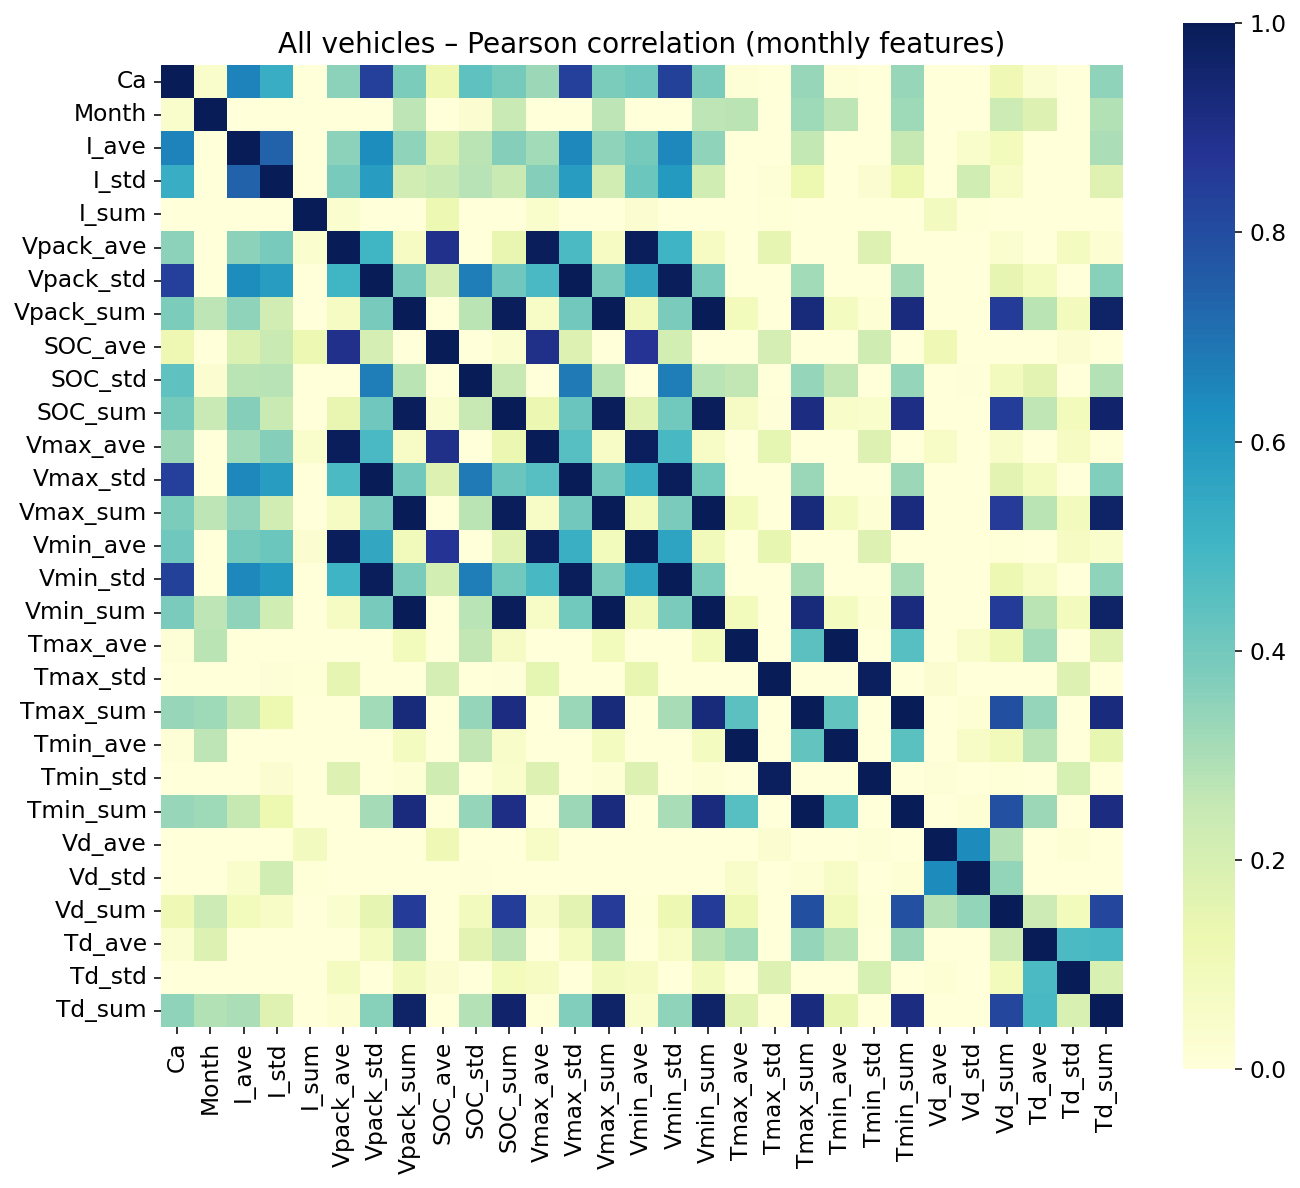

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

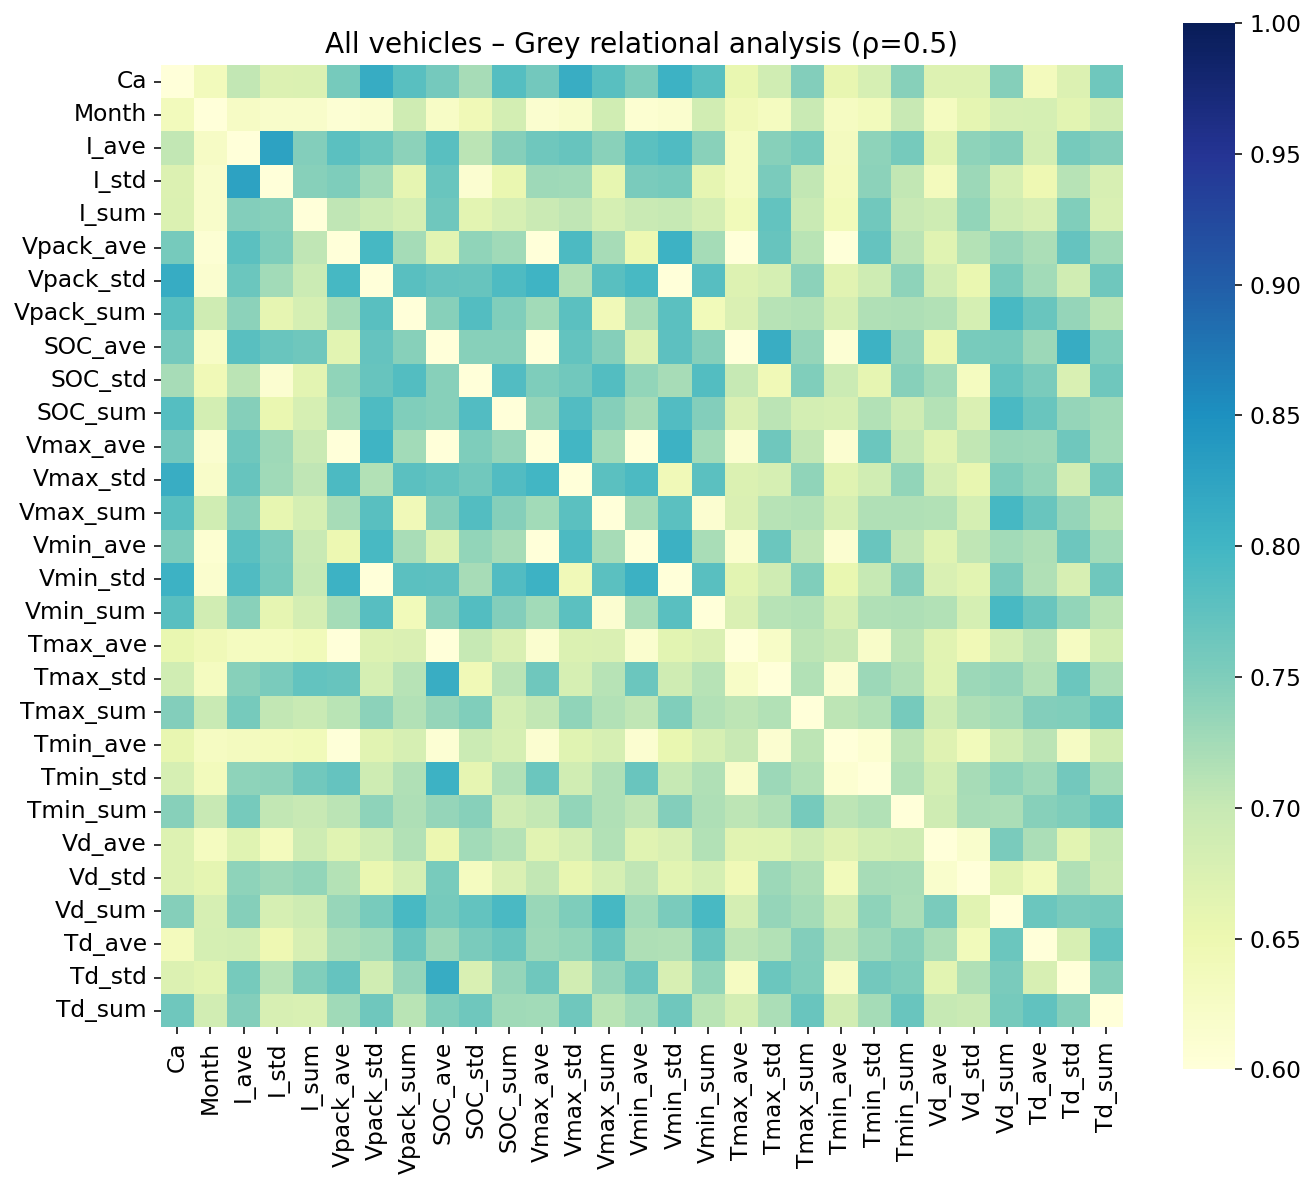


Top 10 features by |Pearson| with Ca:


,abs_PCC_with_Ca
Vmax_std,0.838970
Vpack_std,0.838319
Vmin_std,0.834573
I_ave,0.658180
I_std,0.529145
Vd_ave,0.521041
SOC_std,0.440369
Vmin_ave,0.406788
SOC_sum,0.390741
Vmin_sum,0.383673



Top 10 features by GRG with Ca:


,GRG_with_Ca
Vpack_std,0.813287
Vmax_std,0.811487
Vmin_std,0.805925
SOC_sum,0.783917
Vmin_sum,0.781131
Vmax_sum,0.780971
Vpack_sum,0.780754
Td_sum,0.762742
Vmax_ave,0.759529
SOC_ave,0.758823



Best pick per variable family (choose one among ave/sum/std):


,family,best_feature,abs_PCC_with_Ca,GRG_with_Ca
0,Vmax,Vmax_std,0.838970,0.811487
1,Vpack,Vpack_std,0.838319,0.813287
2,Vmin,Vmin_std,0.834573,0.805925
3,I,I_ave,0.658180,0.704067
4,Vd,Vd_ave,0.521041,0.671567
5,SOC,SOC_std,0.440369,0.722398
6,Td,Td_sum,0.350700,0.762742
7,Tmax,Tmax_sum,0.334810,0.747081
8,Tmin,Tmin_sum,0.332291,0.745129


In [8]:
# === ALL 20 VEHICLES: paper-style features + Pearson & Grey + best-feature picks ===
import os, re, glob, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import datetime as dt
from scipy.integrate import trapezoid

DATA_DIR        = "data"   # change if needed
FILE_GLOB       = "*.csv"  # expects 1.csv ... 20.csv

# --- strict rules (same as your working vehicle-1 cell) ---
GAP_SECONDS     = 10
SESSION_MIN_LEN = 100
SOC_JUMP_POS    = 2.0
SOC_JUMP_NEG    = -0.1
CHARGE_I_THRESH = -0.5        # fallback: consider charging when I < -0.5 A
MAX_MERGE_GAPS  = 2           # when merging charge sub-blocks, allow up to 2*dt
GRG_RHO         = 0.5

# ---------- helpers ----------
def parse_vid(path, fallback):
    m = re.search(r'(\d+)\.csv$', os.path.basename(path))
    return int(m.group(1)) if m else fallback

def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # drop stray "Unnamed" cols
    for c in list(df.columns):
        if str(c).lower().startswith("unnamed"):
            df = df.drop(columns=[c])

    # normalize headers (strip units)
    ren = {c: re.sub(r"\s*\(.*?\)\s*", "", str(c)).strip().lower() for c in df.columns}
    df = df.rename(columns=ren)

    need = ["record_time","soc","pack_voltage","charge_current",
            "max_cell_voltage","min_cell_voltage",
            "max_temperature","min_temperature",
            "available_energy","available_capacity"]
    miss = [n for n in need if n not in df.columns]
    if miss:
        raise ValueError(f"{os.path.basename(path)} missing {miss}")

    # --- robust timestamp parsing: prefer YYYYMMDDhhmmss (14 digits) ---
    rt_raw = df["record_time"].astype(str)
    rt14 = rt_raw.str.extract(r"(\d{14})", expand=False)
    parsed = pd.to_datetime(rt14, format="%Y%m%d%H%M%S", errors="coerce")
    fallback_mask = parsed.isna()
    if fallback_mask.any():
        parsed.loc[fallback_mask] = pd.to_datetime(rt_raw.loc[fallback_mask], errors="coerce")
    df["record_time"] = parsed

    # numeric
    for c in ["soc","pack_voltage","charge_current","max_cell_voltage","min_cell_voltage",
              "max_temperature","min_temperature","available_energy","available_capacity"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["record_time"]).sort_values("record_time").reset_index(drop=True)

    # derived channels (paper)
    df["I"]     = df["charge_current"]
    df["Vpack"] = df["pack_voltage"]
    df["SOC"]   = df["soc"]
    df["Vmax"]  = df["max_cell_voltage"]
    df["Vmin"]  = df["min_cell_voltage"]
    df["Tmax"]  = df["max_temperature"]
    df["Tmin"]  = df["min_temperature"]
    df["Vd"]    = (df["Vmax"] - df["Vmin"]).abs()
    df["Td"]    = (df["Tmax"] - df["Tmin"]).abs()
    return df

def median_dt_seconds(df: pd.DataFrame) -> float:
    d = df["record_time"].diff().dt.total_seconds().dropna()
    return float(np.median(d)) if len(d) else 1.0

def split_by_time_gaps(df: pd.DataFrame):
    t = pd.DataFrame(df["record_time"])
    aaa = t.iloc[1:].reset_index(drop=True)
    bbb = t.iloc[:-1].reset_index(drop=True)
    dts = (aaa - bbb)
    gap = dt.timedelta(seconds=GAP_SECONDS)
    cut = [i for i in range(len(dts)) if dts.iloc[i,0] > gap]
    segs = []
    if not cut:
        segs = [df]
    else:
        segs.append(df.iloc[:cut[0]])
        for i in range(len(cut)-1):
            segs.append(df.iloc[cut[i]+1:cut[i+1]])
        segs.append(df.iloc[cut[-1]+1:])
    return [s.reset_index(drop=True) for s in segs]

def strict_keep(seg: pd.DataFrame) -> bool:
    if len(seg) < SESSION_MIN_LEN:
        return False
    dif_soc = seg["SOC"].iloc[1:].to_numpy() - seg["SOC"].iloc[:-1].to_numpy()
    if np.sum(dif_soc > SOC_JUMP_POS) or np.sum(dif_soc < SOC_JUMP_NEG):
        return False
    return True

def split_by_current(df: pd.DataFrame, dt_sec: float):
    """Fallback: contiguous blocks where I < CHARGE_I_THRESH; merge tiny breaks up to 2*dt."""
    mask = df["I"].to_numpy() < CHARGE_I_THRESH
    segs = []
    start = None
    for i, on in enumerate(mask):
        if on and start is None:
            start = i
        if (not on or i == len(mask)-1) and start is not None:
            end = i if not on else i
            segs.append(df.iloc[start:end+1].copy().reset_index(drop=True))
            start = None
    # merge tiny gaps
    merged = []
    for s in segs:
        if not merged:
            merged.append(s); continue
        last = merged[-1]
        gap = (s["record_time"].iloc[0] - last["record_time"].iloc[-1]).total_seconds()
        if gap <= MAX_MERGE_GAPS * dt_sec:
            merged[-1] = pd.concat([last, s], ignore_index=True)
        else:
            merged.append(s)
    return merged

def capacity_from_segment(seg: pd.DataFrame):
    cur = seg["I"].to_numpy(dtype=float)
    if np.isnan(cur).mean() > 0.1:
        return None
    if np.isnan(cur).any():
        for i in range(1, len(cur)):
            if np.isnan(cur[i]):
                cur[i] = cur[i-1]
    t = pd.to_datetime(seg["record_time"]).to_numpy()
    t0 = t[0]
    secs = np.array([(ti - t0).astype("timedelta64[s]").astype(float) for ti in t], dtype=float)
    Ah = trapezoid(cur, secs)/3600.0 * (-1.0)
    dSOC = float(seg["SOC"].iloc[-1] - seg["SOC"].iloc[0])
    if abs(dSOC) < 1e-9:
        return None
    return Ah / dSOC * 100.0

def add_stats(row, prefix, series):
    x = series.to_numpy(dtype=float)
    row[f"{prefix}_ave"] = float(np.nanmean(x)) if len(x) else np.nan
    row[f"{prefix}_sum"] = float(np.nansum(x)) if len(x) else np.nan
    row[f"{prefix}_std"] = float(np.nanstd(x, ddof=0)) if len(x) else np.nan

def grey_relational_grade_seq(y: np.ndarray, x: np.ndarray, rho=GRG_RHO) -> float:
    def norm(a):
        a = np.asarray(a, dtype=float)
        amin, amax = np.nanmin(a), np.nanmax(a)
        return (a - amin) / (amax - amin + 1e-12)
    y0, x0 = norm(y), norm(x)
    diff = np.abs(y0 - x0)
    dmin, dmax = np.nanmin(diff), np.nanmax(diff)
    xi = (dmin + rho*dmax) / (diff + rho*dmax + 1e-12)
    return float(np.nanmean(xi))

# ---------- per-vehicle feature builder ----------
def features_for_vehicle(path: str, vid_hint=None) -> pd.DataFrame:
    vid = parse_vid(path, vid_hint or 0)
    try:
        df = load_csv(path)
    except Exception as e:
        print(f"[veh {vid}] load error:", e); 
        return pd.DataFrame()

    dt_sec = median_dt_seconds(df)
    segs = [s for s in split_by_time_gaps(df) if strict_keep(s)]
    if not segs:
        segs = [s for s in split_by_current(df, dt_sec) if strict_keep(s)]

    if not segs:
        print(f"[veh {vid}] 0 segments kept (strict+fallback).")
        return pd.DataFrame()

    # capacity per session -> monthly median Ca
    ca_recs = []
    for seg in segs:
        Ca = capacity_from_segment(seg)
        if Ca is None: 
            continue
        m = seg["record_time"].iloc[-1].to_period("M").to_timestamp()
        ca_recs.append({"month": m, "Ca_seg": Ca})
    if not ca_recs:
        print(f"[veh {vid}] sessions exist but 0 with valid Ca.")
        return pd.DataFrame()

    ca_df   = pd.DataFrame(ca_recs)
    ca_month= ca_df.groupby("month")["Ca_seg"].median()

    # charging-only samples; align months with Ca
    df["month_ts"] = df["record_time"].dt.to_period("M").dt.to_timestamp()
    charging = df[df["I"] < 0]
    if charging.empty:
        print(f"[veh {vid}] no charging samples (I<0).")
        return pd.DataFrame()

    rows = []
    for m, grp in charging.groupby("month_ts"):
        if m not in ca_month.index:
            continue
        row = {"vehicle": vid, "month_ts": m, "Month": m.month, "Ca": float(ca_month.loc[m])}
        add_stats(row, "I",     grp["I"])
        add_stats(row, "Vpack", grp["Vpack"])
        add_stats(row, "SOC",   grp["SOC"])
        add_stats(row, "Vmax",  grp["Vmax"])
        add_stats(row, "Vmin",  grp["Vmin"])
        add_stats(row, "Tmax",  grp["Tmax"])
        add_stats(row, "Tmin",  grp["Tmin"])
        add_stats(row, "Vd",    grp["Vd"])
        add_stats(row, "Td",    grp["Td"])
        rows.append(row)

    out = pd.DataFrame(rows).sort_values("month_ts").reset_index(drop=True)
    print(f"[veh {vid}] segments_kept={len(segs)}, months_with_Ca={len(ca_month)}, rows_out={out.shape[0]}")
    return out

# ---------- build combined table for 1..20 ----------
files = sorted(glob.glob(os.path.join(DATA_DIR, FILE_GLOB)), key=lambda p: parse_vid(p, 9999))
all_feat = []
for i, fp in enumerate(files, start=1):
    all_feat.append(features_for_vehicle(fp, vid_hint=i))
feat_df = pd.concat([f for f in all_feat if not f.empty], ignore_index=True)
print("Combined feature table:", feat_df.shape)
display(feat_df.head())

# ---------- correlations across all vehicles ----------
cols_order = [
    "Ca","Month",
    "I_ave","I_std","I_sum",
    "Vpack_ave","Vpack_std","Vpack_sum",
    "SOC_ave","SOC_std","SOC_sum",
    "Vmax_ave","Vmax_std","Vmax_sum",
    "Vmin_ave","Vmin_std","Vmin_sum",
    "Tmax_ave","Tmax_std","Tmax_sum",
    "Tmin_ave","Tmin_std","Tmin_sum",
    "Vd_ave","Vd_std","Vd_sum",
    "Td_ave","Td_std","Td_sum",
]
use_cols = [c for c in cols_order if c in feat_df.columns]
X = feat_df[use_cols].dropna()
print("Rows used for correlation:", len(X))

if len(X) < 2:
    print("Too few rows for correlation. Verify logs or relax rules slightly.")
else:
    # Pearson matrix
    pearson_corr = X.corr(method="pearson")
    plt.figure(figsize=(10,10), dpi=140)
    sns.heatmap(pearson_corr, cmap="YlGnBu", vmin=0, vmax=1, square=True, cbar_kws={"shrink":0.8})
    plt.title("All vehicles – Pearson correlation (monthly features)")
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

    # Grey matrix
    X_np = X.to_numpy(dtype=float)
    grg = pd.DataFrame(index=use_cols, columns=use_cols, dtype=float)
    for i, ci in enumerate(use_cols):
        for j, cj in enumerate(use_cols):
            yi, xj = X_np[:, i], X_np[:, j]
            mask = np.isfinite(yi) & np.isfinite(xj)
            if mask.sum() < 2:
                grg.loc[ci, cj] = np.nan
            else:
                def norm(a):
                    amin, amax = np.nanmin(a), np.nanmax(a)
                    return (a - amin) / (amax - amin + 1e-12)
                y0, x0 = norm(yi[mask]), norm(xj[mask])
                diff = np.abs(y0 - x0)
                dmin, dmax = np.nanmin(diff), np.nanmax(diff)
                xi = (dmin + GRG_RHO*dmax) / (diff + GRG_RHO*dmax + 1e-12)
                grg.loc[ci, cj] = float(np.nanmean(xi))

    plt.figure(figsize=(10,10), dpi=140)
    sns.heatmap(grg.astype(float), cmap="YlGnBu", vmin=0.6, vmax=1.0, square=True, cbar_kws={"shrink":0.8})
    plt.title(f"All vehicles – Grey relational analysis (ρ={GRG_RHO})")
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

    # ---------- top correlations with Ca ----------
    features_only = [c for c in use_cols if c not in ("Ca","Month")]
    # Pearson rank (absolute correlation with Ca)
    pcc_to_ca = pearson_corr.loc[features_only, "Ca"].abs().sort_values(ascending=False)
    top_pcc = pcc_to_ca.head(10).to_frame("abs_PCC_with_Ca")
    print("\nTop 10 features by |Pearson| with Ca:")
    display(top_pcc)

    # GRG rank vs Ca
    if "Ca" in grg.columns:
        grg_to_ca = grg.loc[features_only, "Ca"].sort_values(ascending=False)
        top_grg = grg_to_ca.head(10).to_frame("GRG_with_Ca")
        print("\nTop 10 features by GRG with Ca:")
        display(top_grg)

    # ---------- best pick per variable family (like the paper) ----------
    families = {
        "I":     [c for c in features_only if c.startswith("I_")],
        "Vpack": [c for c in features_only if c.startswith("Vpack_")],
        "SOC":   [c for c in features_only if c.startswith("SOC_")],
        "Vmax":  [c for c in features_only if c.startswith("Vmax_")],
        "Vmin":  [c for c in features_only if c.startswith("Vmin_")],
        "Tmax":  [c for c in features_only if c.startswith("Tmax_")],
        "Tmin":  [c for c in features_only if c.startswith("Tmin_")],
        "Vd":    [c for c in features_only if c.startswith("Vd_")],
        "Td":    [c for c in features_only if c.startswith("Td_")],
    }

    rows = []
    for fam, cols in families.items():
        if not cols: 
            continue
        # best by absolute PCC with Ca
        pcc_vals = pearson_corr.loc[cols, "Ca"].abs()
        best_pcc_col = pcc_vals.idxmax()
        best_pcc_val = pcc_vals.loc[best_pcc_col]
        # corresponding GRG (if available)
        best_grg_val = float(grg.loc[best_pcc_col, "Ca"]) if ("Ca" in grg.columns and best_pcc_col in grg.index) else np.nan
        rows.append({"family": fam, "best_feature": best_pcc_col, "abs_PCC_with_Ca": float(best_pcc_val), "GRG_with_Ca": best_grg_val})

    best_per_family = pd.DataFrame(rows).sort_values("abs_PCC_with_Ca", ascending=False).reset_index(drop=True)
    print("\nBest pick per variable family (choose one among ave/sum/std):")
    display(best_per_family)


In [11]:
# --- Persist feature table + analysis artifacts ---
import os, json
import pandas as pd

ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# a tiny version tag so you can keep multiple extracts side-by-side if you want
TAG = "v1"

# 1) main feature table
feat_df_to_save = feat_df.copy()
# make sure month_ts is a clean ISO string in CSV (parquet keeps dtype anyway)
feat_df_to_save["month_ts"] = pd.to_datetime(feat_df_to_save["month_ts"]).dt.strftime("%Y-%m-%d")

feat_csv     = os.path.join(ART_DIR, f"feat_df_{TAG}.csv")
feat_parquet = os.path.join(ART_DIR, f"feat_df_{TAG}.parquet")

feat_df_to_save.to_csv(feat_csv, index=False)
try:
    feat_df_to_save.to_parquet(feat_parquet, index=False)
except Exception as e:
    print("Parquet save skipped:", e)

# 2) correlation matrices
pearson_csv = os.path.join(ART_DIR, f"corr_pearson_{TAG}.csv")
grg_csv     = os.path.join(ART_DIR, f"corr_grg_{TAG}.csv")
pearson_corr.to_csv(pearson_csv)
grg.to_csv(grg_csv)

# 3) rankings / picks
top_pcc.to_csv(os.path.join(ART_DIR, f"top_by_abs_pearson_{TAG}.csv"))
if "top_grg" in globals():
    top_grg.to_csv(os.path.join(ART_DIR, f"top_by_grg_{TAG}.csv"))
best_per_family.to_csv(os.path.join(ART_DIR, f"best_per_family_{TAG}.csv"), index=False)

# 4) minimal metadata so you remember how this was built
with open(os.path.join(ART_DIR, f"feat_df_meta_{TAG}.json"), "w") as f:
    json.dump({
        "extracted_at": pd.Timestamp.now().isoformat(timespec="seconds"),
        "n_rows": int(len(feat_df_to_save)),
        "n_cols": int(feat_df_to_save.shape[1]),
        "columns": list(feat_df_to_save.columns),
        "params": {
            "GAP_SECONDS": GAP_SECONDS,
            "SESSION_MIN_LEN": SESSION_MIN_LEN,
            "SOC_JUMP_POS": SOC_JUMP_POS,
            "SOC_JUMP_NEG": SOC_JUMP_NEG,
            "CHARGE_I_THRESH": CHARGE_I_THRESH,
            "MAX_MERGE_GAPS": MAX_MERGE_GAPS,
            "GRG_RHO": GRG_RHO,
        }
    }, f, indent=2)

print("Saved:",
      "\n  ", feat_csv,
      "\n  ", pearson_csv,
      "\n  ", grg_csv,
      "\n  ", os.path.join(ART_DIR, f"best_per_family_{TAG}.csv"),
      "\n(Parquet saved too if supported.)")


Saved: 
   artifacts/feat_df_v1.csv 
   artifacts/corr_pearson_v1.csv 
   artifacts/corr_grg_v1.csv 
   artifacts/best_per_family_v1.csv 
(Parquet saved too if supported.)


In [12]:
import os, pandas as pd

ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# Clean + stable ordering
out = (
    feat_df.copy()
    .sort_values(["vehicle", "month_ts"])
    .drop_duplicates(["vehicle", "month_ts"])    # avoid accidental dup rows
)

# store timestamp as ISO string so CSV round-trips cleanly
out["month_ts"] = pd.to_datetime(out["month_ts"]).dt.strftime("%Y-%m-%d")

CSV_PATH = os.path.join(ART_DIR, "feat_df_all_vehicles.csv")
out.to_csv(CSV_PATH, index=False)

print(f"Saved {len(out)} rows from {out['vehicle'].nunique()} vehicles -> {CSV_PATH}")


Saved 571 rows from 20 vehicles -> artifacts/feat_df_all_vehicles.csv


[Split] Train veh: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[Split] Test  veh: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

=== Test metrics (overall) ===
SVR  -> MAE: 2.249 Ah | RMSE: 3.009 Ah
GPR  -> MAE: 1.460 Ah | RMSE: 1.921 Ah

Vehicles chosen for plots: [12, 16]


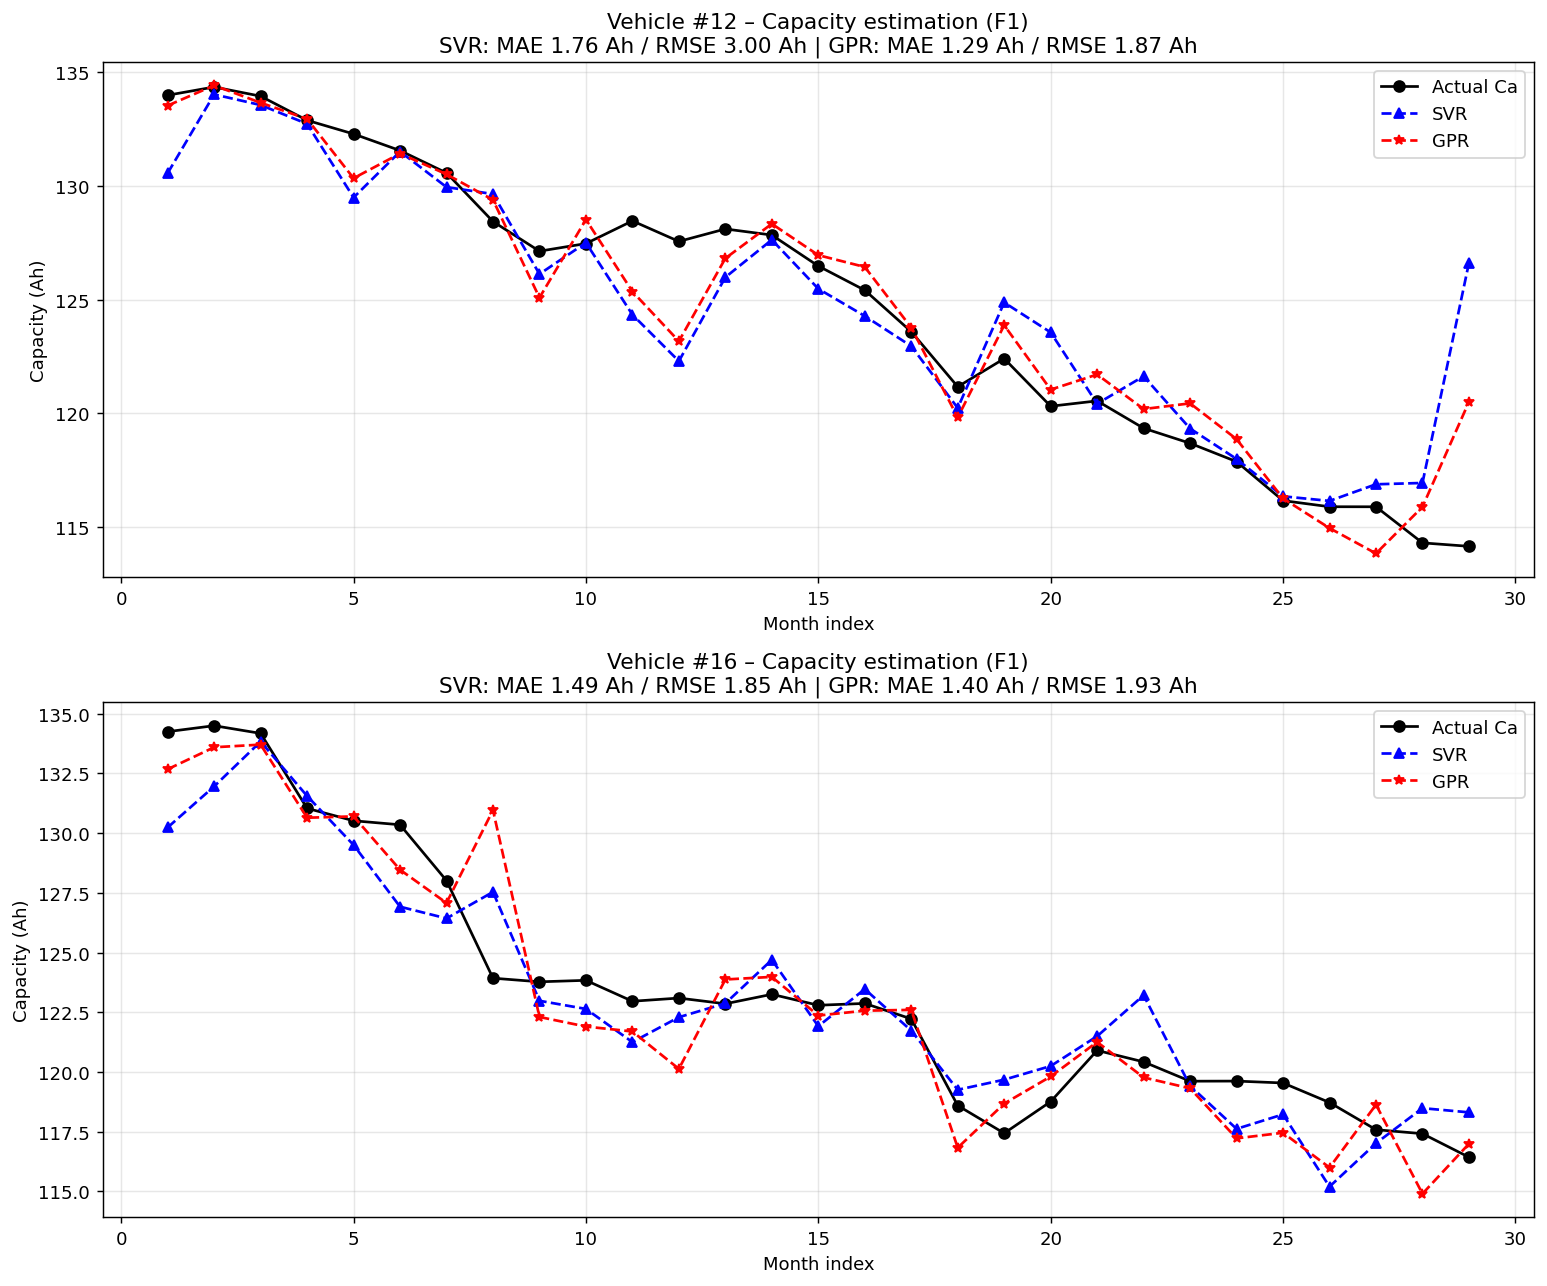

In [7]:
# === PAPER STEP 1: Capacity Estimation with SVR & GPR (F1), 10 train / 10 test + 2 time-series plots ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_absolute_error

# ---- feature set F1 (paper) ----
F1 = ["I_ave","I_std","Vpack_sum","Vpack_std","SOC_std","Tmax_sum","Vd_ave","Td_sum"]
FEATURES = F1

# ---- sanity checks ----
need = ["vehicle","month_ts","Ca"] + FEATURES
missing = [c for c in need if c not in feat_df.columns]
if missing:
    raise ValueError(f"feat_df missing: {missing}")

# keep only rows that have labels + features
df = feat_df.dropna(subset=["Ca"] + FEATURES).copy()
df["vehicle"] = df["vehicle"].astype(int)
df = df.sort_values(["vehicle","month_ts"]).reset_index(drop=True)

# ---- split: 10 vehicles train, 10 test (or as many as available) ----
veh_all = sorted(df["vehicle"].unique().tolist())
if len(veh_all) >= 20:
    train_veh = veh_all[:10]
    test_veh  = veh_all[10:20]
else:
    half = max(1, len(veh_all)//2)
    train_veh = veh_all[:half]
    test_veh  = veh_all[half:]
print(f"[Split] Train veh: {train_veh}\n[Split] Test  veh: {test_veh}")

train = df[df["vehicle"].isin(train_veh)].copy()
test  = df[df["vehicle"].isin(test_veh)].copy()

X_tr = train[FEATURES].values
y_tr = train["Ca"].values
X_te = test[FEATURES].values
y_te = test["Ca"].values

scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_te_s = scaler.transform(X_te)

# ---- SVR (RBF) ----
svr = SVR(kernel="rbf")
svr.fit(X_tr_s, y_tr)
svr_pred = svr.predict(X_te_s)

# ---- GPR (RBF + noise) ----
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(X_tr_s.shape[1]), length_scale_bounds=(1e-2, 1e3)) + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)
gpr.fit(X_tr_s, y_tr)
gpr_pred, gpr_std = gpr.predict(X_te_s, return_std=True)

# ---- metrics (overall on test set) ----
def rmse(y, p): return float(np.sqrt(np.mean((np.asarray(y)-np.asarray(p))**2)))
print("\n=== Test metrics (overall) ===")
print("SVR  -> MAE: {:.3f} Ah | RMSE: {:.3f} Ah".format(mean_absolute_error(y_te, svr_pred), rmse(y_te, svr_pred)))
print("GPR  -> MAE: {:.3f} Ah | RMSE: {:.3f} Ah".format(mean_absolute_error(y_te, gpr_pred), rmse(y_te, gpr_pred)))

# ---- choose two test vehicles with most months for clearer plots ----
counts = test.groupby("vehicle")["month_ts"].count().sort_values(ascending=False)
plot_veh = counts.index.tolist()[:2] if len(counts) >= 2 else counts.index.tolist()
print("\nVehicles chosen for plots:", plot_veh)

# attach predictions per row to the test table for plotting
test = test.copy()
test["SVR_pred"] = svr.predict(scaler.transform(test[FEATURES].values))
test["GPR_pred"] = gpr.predict(scaler.transform(test[FEATURES].values))

# ---- plot: actual Ca vs SVR & GPR for the two vehicles over time ----
plt.figure(figsize=(12,5*len(plot_veh)), dpi=130)
for i, vid in enumerate(plot_veh, 1):
    sub = test[test["vehicle"]==vid].sort_values("month_ts").reset_index(drop=True)
    # a simple month index for x-axis (paper shows Month timeline)
    sub["t"] = np.arange(1, len(sub)+1)

    ax = plt.subplot(len(plot_veh),1,i)
    ax.plot(sub["t"], sub["Ca"], "ko-", label="Actual Ca")
    ax.plot(sub["t"], sub["SVR_pred"], "b^--", label="SVR")
    ax.plot(sub["t"], sub["GPR_pred"], "r*--", label="GPR")

    mae_svr  = mean_absolute_error(sub["Ca"], sub["SVR_pred"])
    mae_gpr  = mean_absolute_error(sub["Ca"], sub["GPR_pred"])
    rmse_svr = rmse(sub["Ca"], sub["SVR_pred"])
    rmse_gpr = rmse(sub["Ca"], sub["GPR_pred"])

    ax.set_title(f"Vehicle #{vid} – Capacity estimation (F1)\n"
                 f"SVR: MAE {mae_svr:.2f} Ah / RMSE {rmse_svr:.2f} Ah | "
                 f"GPR: MAE {mae_gpr:.2f} Ah / RMSE {rmse_gpr:.2f} Ah")
    ax.set_xlabel("Month index")
    ax.set_ylabel("Capacity (Ah)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
plt.tight_layout()
plt.show()


2025-10-31 19:16:19.072346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 19:16:19.630592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[Split] Train vehicles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[Split] Test  vehicles: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

[Seq2Seq] Training...
Epoch 1/300


2025-10-31 19:16:42.316994: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 14644.6533 - val_loss: 14360.1738 - learning_rate: 1.0000e-04
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 14638.2002 - val_loss: 14353.7441 - learning_rate: 1.0000e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 14631.6953 - val_loss: 14347.2490 - learning_rate: 1.0000e-04
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 14625.1240 - val_loss: 14340.6523 - learning_rate: 1.0000e-04
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 14618.4561 - val_loss: 14333.9297 - learning_rate: 1.0000e-04
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 14611.6641 - val_loss: 14327.0391 - learning_rate: 1.0000e-04
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 14604.7090 - val_loss: 14319.9502 - learning_rate: 1.0000e-04
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 14597.5586 - val_loss: 14312.6211 - learning_rate: 1.0000e-04
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms

/tmp/ipykernel_3114/251704873.py:187: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tm = pd.DataFrame({"Month": mon}).merge(Tref, on="Month", how="left").fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3114/251704873.py:187: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tm = pd.DataFrame({"Month": mon}).merge(Tref, on="Month", how="left").fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3114/251704873.py:187: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tm = pd.DataFrame({"Month": mon}).merge(Tref, on="Month", how="left").fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3114/251704873.py:187: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future

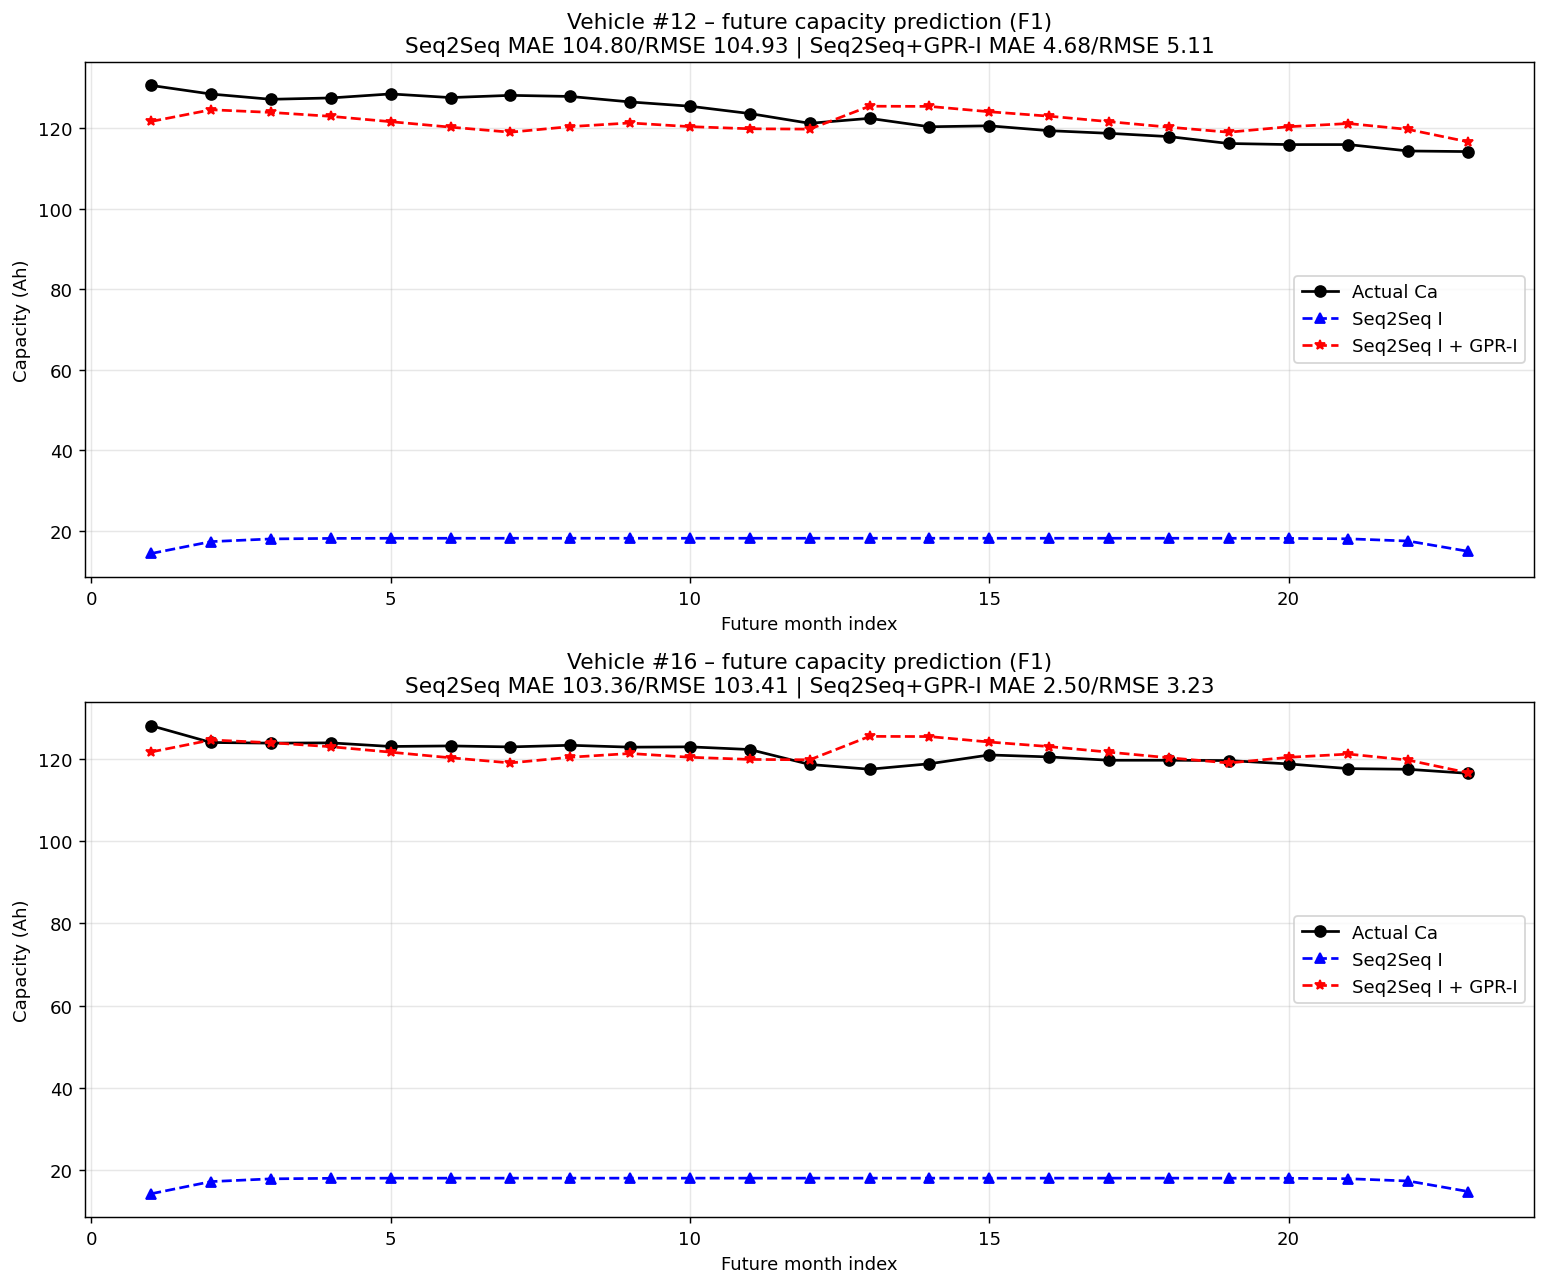


[Saved]
 - artifacts/seq2seq_f1.keras
 - artifacts/z_scaler.pkl
 - artifacts/x2_scaler.pkl
 - artifacts/gpr_residual.pkl
 - artifacts/features_f1.json
 - artifacts/inference_wrapper.py


In [8]:
# === PAPER BEST MODEL: Seq2Seq I (Bi-LSTM) + GPR-I residual compensation, feature set F1 ===
# Artifacts saved to ./artifacts/ for Raspberry Pi use

import os, json, time, math, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_absolute_error
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

np.random.seed(42); random.seed(42); tf.random.set_seed(42)

# ------------------ 0) Expecting your monthly feature table ------------------
# feat_df columns must include (as we built earlier):
# ['vehicle','month_ts','Month','Ca','I_ave','I_std','I_sum','Vpack_ave','Vpack_std','Vpack_sum',
#  'SOC_ave','SOC_std','SOC_sum','Vmax_ave','Vmax_std','Vmax_sum','Vmin_ave','Vmin_std','Vmin_sum',
#  'Tmax_ave','Tmax_std','Tmax_sum','Tmin_ave','Tmin_std','Tmin_sum','Vd_ave','Vd_std','Vd_sum',
#  'Td_ave','Td_std','Td_sum']

# ------------------ 1) Paper feature set (F1) ------------------
F1 = ["I_ave","I_std","Vpack_sum","Vpack_std","SOC_std","Tmax_sum","Vd_ave","Td_sum"]
USE_FEATURES = F1

REQUIRED = ["vehicle","month_ts","Month","Ca","Tmax_ave","Tmin_ave"] + USE_FEATURES
missing = [c for c in REQUIRED if c not in feat_df.columns]
if missing:
    raise ValueError(f"feat_df missing columns: {missing}")

df = feat_df.dropna(subset=["Ca"] + USE_FEATURES + ["Tmax_ave","Tmin_ave"]).copy()
df["vehicle"] = df["vehicle"].astype(int)
df = df.sort_values(["vehicle","month_ts"]).reset_index(drop=True)

vehicles = sorted(df["vehicle"].unique().tolist())
if len(vehicles) < 12:
    print(f"[warn] only {len(vehicles)} vehicles with labels; still proceeding")

# Split as paper: 10 for train, 10 for test (or half/half if fewer)
if len(vehicles) >= 20:
    train_vids, test_vids = vehicles[:10], vehicles[10:20]
else:
    h = max(1, len(vehicles)//2)
    train_vids, test_vids = vehicles[:h], vehicles[h:]
print(f"[Split] Train vehicles: {train_vids}\n[Split] Test  vehicles: {test_vids}")

# ------------------ 2) Sequence set-up (first 6 months known -> predict next up to 23) ------------------
N_KNOWN = 6
P_FUTURE = 23

# Build per-vehicle sequences
seq_data = {}
for vid, g in df.groupby("vehicle"):
    g = g.sort_values("month_ts").reset_index(drop=True)
    if len(g) <= N_KNOWN: 
        continue
    seq_data[vid] = {
        "c": g["Ca"].values.astype(float),                  # capacity sequence
        "X1": g[USE_FEATURES].values.astype(float),         # features sequence
        "Month": g["Month"].values.astype(int),
        "Tmax_ave": g["Tmax_ave"].values.astype(float),
        "Tmin_ave": g["Tmin_ave"].values.astype(float),
        "month_ts": g["month_ts"].values
    }

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

# ------------------ 3) Build scalers from TRAIN vehicles only ------------------
def build_z_scaler(train_vids):
    Z = []
    for v in train_vids:
        d = seq_data.get(v)
        if d is None or len(d["c"]) < N_KNOWN: 
            continue
        # first N_KNOWN rows: [capacity] + features
        Z.append(np.c_[ d["c"][:N_KNOWN].reshape(-1,1), d["X1"][:N_KNOWN,:] ])
    Z = np.vstack(Z)
    scaler = MinMaxScaler().fit(Z)
    return scaler

z_scaler = build_z_scaler(train_vids)

def make_io_for_vids(vid_list, z_scaler):
    X_list, Y_list, aux_list = [], [], []
    for v in vid_list:
        d = seq_data.get(v)
        if d is None or len(d["c"]) <= N_KNOWN: 
            continue
        p = min(P_FUTURE, len(d["c"]) - N_KNOWN)
        if p <= 0: continue
        X_in = np.c_[ d["c"][:N_KNOWN].reshape(-1,1), d["X1"][:N_KNOWN,:] ]
        X_in_s = z_scaler.transform(X_in)
        Y_out = d["c"][N_KNOWN:N_KNOWN+p].reshape(-1,1)

        Y_pad = np.zeros((P_FUTURE,1), dtype=float)
        Y_pad[:p,:] = Y_out

        aux = {
            "vid": v,
            "p": p,
            "Month": d["Month"][N_KNOWN:N_KNOWN+p],
            "Tmax_ave": d["Tmax_ave"][N_KNOWN:N_KNOWN+p],
            "Tmin_ave": d["Tmin_ave"][N_KNOWN:N_KNOWN+p],
            "Y_true": Y_out.squeeze(-1),
            "month_ts": d["month_ts"][N_KNOWN:N_KNOWN+p]
        }
        X_list.append(X_in_s); Y_list.append(Y_pad); aux_list.append(aux)
    if not X_list:
        return None, None, None
    X = np.stack(X_list)  # (N, N_KNOWN, 1+m)
    Y = np.stack(Y_list)  # (N, P_FUTURE, 1)
    return X, Y, aux_list

Xtr, Ytr, aux_tr = make_io_for_vids(train_vids, z_scaler)
Xte, Yte, aux_te = make_io_for_vids(test_vids, z_scaler)

if Xtr is None or Xte is None:
    raise RuntimeError("Not enough data after N_KNOWN slicing to build train/test sequences.")

# ------------------ 4) Seq2Seq I model (as in paper) ------------------
def build_seq2seq(n_steps, n_feats, p_steps):
    inp = layers.Input(shape=(n_steps, n_feats))
    x = layers.Masking(mask_value=0.0)(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.RepeatVector(p_steps)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    out = layers.TimeDistributed(layers.Dense(1))(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse")
    return model

model = build_seq2seq(N_KNOWN, Xtr.shape[-1], P_FUTURE)
es = callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1)

print("\n[Seq2Seq] Training...")
t0 = time.time()
hist = model.fit(
    Xtr, Ytr, 
    validation_split=0.2,
    epochs=300, batch_size=16, verbose=1,
    callbacks=[es, rlr]
)
print(f"[Seq2Seq] Done in {time.time()-t0:.1f}s. Best val_loss={min(hist.history['val_loss']):.6f}")

Ytr_hat = model.predict(Xtr, verbose=0)  # (N, P, 1)
Yte_hat = model.predict(Xte, verbose=0)

# ------------------ 5) GPR-I residual model ------------------
# Build residuals from TRAIN vehicles only: r = y_true - y_hat for each future step available
R_list, X2_list = [], []
for i, a in enumerate(aux_tr):
    p = a["p"]
    y_true = Ytr[i,:p,0]; y_hat = Ytr_hat[i,:p,0]
    R_list.append(y_true - y_hat)
    X2_list.append( np.c_[ a["Month"], a["Tmax_ave"], a["Tmin_ave"] ] )
R = np.concatenate(R_list)
X2 = np.vstack(X2_list)

x2_scaler = StandardScaler().fit(X2)
X2s = x2_scaler.transform(X2)

kernel = C(1.0, (1e-3, 1e3))*RBF(length_scale=[1.0,1.0,1.0], length_scale_bounds=(1e-2, 1e3)) + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42, n_restarts_optimizer=5)
print("\n[GPR-I] Fitting residual model...")
t0 = time.time()
gpr.fit(X2s, R)
print(f"[GPR-I] Done in {time.time()-t0:.1f}s. Kernel: {gpr.kernel_}")

# ------------------ 6) Apply GPR-I to TEST vehicles & evaluate ------------------
# For test vehicles, future temperature features are set to the average (per calendar Month) of training vehicles.
Tref = []
for v in train_vids:
    d = seq_data.get(v)
    if d is None: continue
    Tref.append(pd.DataFrame({"Month": d["Month"], "Tmax_ave": d["Tmax_ave"], "Tmin_ave": d["Tmin_ave"]}))
Tref = pd.concat(Tref, ignore_index=True).groupby("Month").agg(Tmax_ave=("Tmax_ave","mean"), Tmin_ave=("Tmin_ave","mean")).reset_index()

Yte_hat_adj = Yte_hat.copy()
for i, a in enumerate(aux_te):
    p = a["p"]
    mon = a["Month"]
    tm = pd.DataFrame({"Month": mon}).merge(Tref, on="Month", how="left").fillna(method="ffill").fillna(method="bfill")
    X2_te = np.c_[ mon, tm["Tmax_ave"].values, tm["Tmin_ave"].values ]
    X2_te_s = x2_scaler.transform(X2_te)
    r_hat = gpr.predict(X2_te_s)
    Yte_hat_adj[i,:p,0] += r_hat

# Gather test ground truth and predictions (ignoring padded tail)
all_true, all_seq2seq, all_seq2seq_gpr = [], [], []
for i, a in enumerate(aux_te):
    p = a["p"]
    all_true.append( Yte[i,:p,0] )
    all_seq2seq.append( Yte_hat[i,:p,0] )
    all_seq2seq_gpr.append( Yte_hat_adj[i,:p,0] )

y_true = np.concatenate(all_true)
y_hat1 = np.concatenate(all_seq2seq)
y_hat2 = np.concatenate(all_seq2seq_gpr)

print("\n=== TEST metrics (future months only) ===")
print("Seq2Seq I           -> MAE: {:.3f} Ah | RMSE: {:.3f} Ah".format(mean_absolute_error(y_true, y_hat1), rmse(y_true, y_hat1)))
print("Seq2Seq I + GPR-I   -> MAE: {:.3f} Ah | RMSE: {:.3f} Ah".format(mean_absolute_error(y_true, y_hat2), rmse(y_true, y_hat2)))

# ------------------ 7) Plots for two test vehicles (Actual vs Predicted) ------------------
# choose two with most months
lengths = [(a["vid"], a["p"]) for a in aux_te]
lengths = sorted(lengths, key=lambda x: -x[1])
plot_vids = [v for v,_ in lengths[:2]] if lengths else [test_vids[0]]

plt.figure(figsize=(12, 5*len(plot_vids)), dpi=130)
plot_i = 1
for vid in plot_vids:
    # find index of this vid in aux_te
    idx = next(i for i,a in enumerate(aux_te) if a["vid"]==vid)
    a = aux_te[idx]
    p = a["p"]; t = np.arange(1, p+1)
    y = Yte[idx,:p,0]; s1 = Yte_hat[idx,:p,0]; s2 = Yte_hat_adj[idx,:p,0]

    ax = plt.subplot(len(plot_vids), 1, plot_i); plot_i += 1
    ax.plot(t, y, "ko-", label="Actual Ca")
    ax.plot(t, s1, "b^--", label="Seq2Seq I")
    ax.plot(t, s2, "r*--", label="Seq2Seq I + GPR-I")

    ax.set_title(f"Vehicle #{vid} – future capacity prediction (F1)\n"
                 f"Seq2Seq MAE {mean_absolute_error(y,s1):.2f}/RMSE {rmse(y,s1):.2f} | "
                 f"Seq2Seq+GPR-I MAE {mean_absolute_error(y,s2):.2f}/RMSE {rmse(y,s2):.2f}")
    ax.set_xlabel("Future month index")
    ax.set_ylabel("Capacity (Ah)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

plt.tight_layout(); plt.show()

# ------------------ 8) Save artifacts for Raspberry Pi ------------------
os.makedirs("artifacts", exist_ok=True)

# NN
model.save("artifacts/seq2seq_f1.keras")
# Scalers and GPR
joblib.dump(z_scaler, "artifacts/z_scaler.pkl")
joblib.dump(x2_scaler, "artifacts/x2_scaler.pkl")
joblib.dump(gpr, "artifacts/gpr_residual.pkl")
# Feature list
with open("artifacts/features_f1.json","w") as f:
    json.dump(USE_FEATURES, f, indent=2)

# Minimal inference wrapper (loads everything and predicts P_FUTURE months from 6 known)
wrapper = r'''
import json, joblib, numpy as np, tensorflow as tf

class SOHPredictor:
    def __init__(self, artifacts_dir="artifacts"):
        self.model = tf.keras.models.load_model(f"{artifacts_dir}/seq2seq_f1.keras")
        self.z_scaler = joblib.load(f"{artifacts_dir}/z_scaler.pkl")
        self.x2_scaler = joblib.load(f"{artifacts_dir}/x2_scaler.pkl")
        self.gpr = joblib.load(f"{artifacts_dir}/gpr_residual.pkl")
        with open(f"{artifacts_dir}/features_f1.json") as f:
            self.features = json.load(f)
        self.N_KNOWN = 6
        self.P_FUTURE = 23

    def predict_future(self, known_capacity_6, known_feature_6, future_months, future_tmax=None, future_tmin=None):
        # known_capacity_6: (6,) array
        # known_feature_6:  (6, len(features)) array
        # future_months:    (p,) integers in [1..12]
        # future_tmax/min:  (p,) arrays; if None, they are set to the last known values
        p = min(self.P_FUTURE, len(future_months))
        X_in = np.c_[ np.asarray(known_capacity_6).reshape(-1,1), np.asarray(known_feature_6) ]
        X_in_s = self.z_scaler.transform(X_in)
        X = X_in_s[None, ...]  # (1,6,1+m)
        Y_hat = self.model.predict(X, verbose=0)[0,:p,0]  # (p,)

        if future_tmax is None: future_tmax = np.repeat(known_feature_6[-1, self.features.index("Tmax_sum")] if "Tmax_sum" in self.features else 0.0, p)
        if future_tmin is None: future_tmin = np.repeat(0.0, p)

        X2 = np.c_[ np.asarray(future_months[:p]), np.asarray(future_tmax)[:p], np.asarray(future_tmin)[:p] ]
        X2s = self.x2_scaler.transform(X2)
        resid = self.gpr.predict(X2s)
        return (Y_hat + resid).astype(float)
'''
with open("artifacts/inference_wrapper.py","w") as f:
    f.write(wrapper)

print("\n[Saved]")
print(" - artifacts/seq2seq_f1.keras")
print(" - artifacts/z_scaler.pkl")
print(" - artifacts/x2_scaler.pkl")
print(" - artifacts/gpr_residual.pkl")
print(" - artifacts/features_f1.json")
print(" - artifacts/inference_wrapper.py")


/tmp/ipykernel_3114/4180843454.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tm = tm.merge(Tref, on="Month", how="left").fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3114/4180843454.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tm = tm.merge(Tref, on="Month", how="left").fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3114/4180843454.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tm = tm.merge(Tref, on="Month", how="left").fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3114/4180843454.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tm = tm.merge(Tref, on="Mo

[Vehicle #12]  Block (first6->all)  MAE=4.68 Ah | RMSE=5.11 Ah
[Vehicle #12]  Rolling (1-step)     MAE=5.11 Ah | RMSE=6.73 Ah


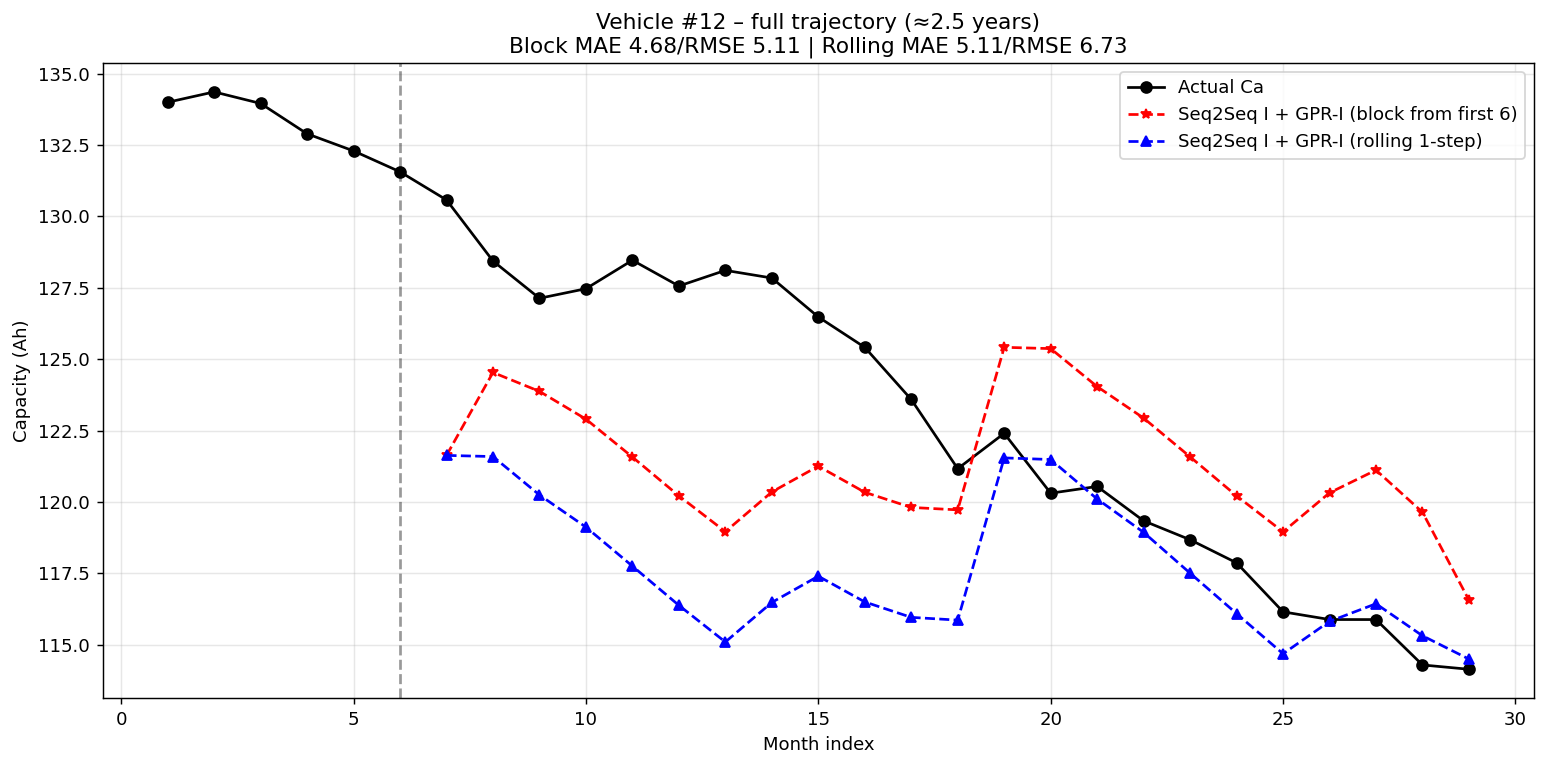

In [9]:
# === Full-trajectory plotting for one vehicle (Seq2Seq I + GPR-I) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def _rmse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

def _residual_adjust(month_vec):
    tm = pd.DataFrame({"Month": month_vec})
    tm = tm.merge(Tref, on="Month", how="left").fillna(method="ffill").fillna(method="bfill")
    X2 = np.c_[ month_vec, tm["Tmax_ave"].values, tm["Tmin_ave"].values ]
    return gpr.predict(x2_scaler.transform(X2))

def forecast_full_from_first6(vid):
    """Paper-style: first 6 known -> predict all remaining months at once."""
    d = seq_data[vid]
    n = len(d["c"])
    p = n - N_KNOWN
    X_in = np.c_[ d["c"][:N_KNOWN].reshape(-1,1), d["X1"][:N_KNOWN,:] ]
    X_in_s = z_scaler.transform(X_in)[None, ...]
    y_hat = model.predict(X_in_s, verbose=0)[0, :p, 0]                 # Seq2Seq prediction
    resid = _residual_adjust(d["Month"][N_KNOWN:N_KNOWN+p])            # GPR residuals
    y_pred = y_hat + resid
    t = np.arange(1, n+1)
    y_full = np.r_[ [np.nan]*N_KNOWN, y_pred ]
    return t, d["c"], y_full

def forecast_rolling_1step(vid):
    """Walk-forward: for each month k>N_KNOWN, use previous 6 months to predict month k."""
    d = seq_data[vid]
    n = len(d["c"])
    preds = []
    months = []
    for k in range(N_KNOWN, n):
        X_win = np.c_[ d["c"][k-N_KNOWN:k].reshape(-1,1), d["X1"][k-N_KNOWN:k,:] ]
        X_win_s = z_scaler.transform(X_win)[None, ...]
        next_pred = model.predict(X_win_s, verbose=0)[0, 0, 0]         # first step of decoder
        resid = _residual_adjust(np.array([d["Month"][k]]))[0]
        preds.append(next_pred + resid)
        months.append(k+1)
    t = np.arange(1, n+1)
    y_roll = np.r_[ [np.nan]*N_KNOWN, np.array(preds) ]
    return t, d["c"], y_roll

# ---- Choose a test vehicle (pick one you saw in the earlier test set, e.g., 12 or 16) ----
VID = 12  # change to any available vehicle id

# Compute forecasts
t_full, y_act, y_block = forecast_full_from_first6(VID)
t_roll, _,   y_roll  = forecast_rolling_1step(VID)

# Metrics (only on predicted region)
mask_block = ~np.isnan(y_block)
mae_block = mean_absolute_error(y_act[mask_block], y_block[mask_block])
rmse_block = _rmse(y_act[mask_block], y_block[mask_block])

mask_roll = ~np.isnan(y_roll)
mae_roll = mean_absolute_error(y_act[mask_roll], y_roll[mask_roll])
rmse_roll = _rmse(y_act[mask_roll], y_roll[mask_roll])

print(f"[Vehicle #{VID}]  Block (first6->all)  MAE={mae_block:.2f} Ah | RMSE={rmse_block:.2f} Ah")
print(f"[Vehicle #{VID}]  Rolling (1-step)     MAE={mae_roll:.2f} Ah | RMSE={rmse_roll:.2f} Ah")

# Plot
plt.figure(figsize=(12,6), dpi=130)
plt.plot(t_full, y_act, "ko-", label="Actual Ca")
plt.plot(t_full, y_block, "r*--", label="Seq2Seq I + GPR-I (block from first 6)")
plt.plot(t_roll, y_roll,  "b^--", label="Seq2Seq I + GPR-I (rolling 1-step)")
plt.axvline(N_KNOWN, color="k", linestyle="--", alpha=0.4)
plt.title(f"Vehicle #{VID} – full trajectory (≈2.5 years)\n"
          f"Block MAE {mae_block:.2f}/RMSE {rmse_block:.2f} | "
          f"Rolling MAE {mae_roll:.2f}/RMSE {rmse_roll:.2f}")
plt.xlabel("Month index")
plt.ylabel("Capacity (Ah)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


[Split] Train vehicles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[Split] Test  vehicles: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

[Seq2Seq] Training...
Epoch 1/120
1/1 - 9s - 9s/step - loss: 0.7495 - val_loss: 1.4274 - learning_rate: 0.0010
Epoch 2/120
1/1 - 0s - 173ms/step - loss: 0.4390 - val_loss: 1.1656 - learning_rate: 0.0010
Epoch 3/120
1/1 - 0s - 171ms/step - loss: 0.2718 - val_loss: 0.9912 - learning_rate: 0.0010
Epoch 4/120
1/1 - 0s - 168ms/step - loss: 0.1984 - val_loss: 0.8846 - learning_rate: 0.0010
Epoch 5/120
1/1 - 0s - 200ms/step - loss: 0.1876 - val_loss: 0.8144 - learning_rate: 0.0010
Epoch 6/120
1/1 - 0s - 187ms/step - loss: 0.1834 - val_loss: 0.7607 - learning_rate: 0.0010
Epoch 7/120
1/1 - 0s - 195ms/step - loss: 0.1592 - val_loss: 0.7257 - learning_rate: 0.0010
Epoch 8/120
1/1 - 0s - 182ms/step - loss: 0.1324 - val_loss: 0.7182 - learning_rate: 0.0010
Epoch 9/120
1/1 - 0s - 185ms/step - loss: 0.1188 - val_loss: 0.7333 - learning_rate: 0.0010
Epoch 10/120
1/1 - 0s - 198ms/s

/home/kafkayash/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kafkayash/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


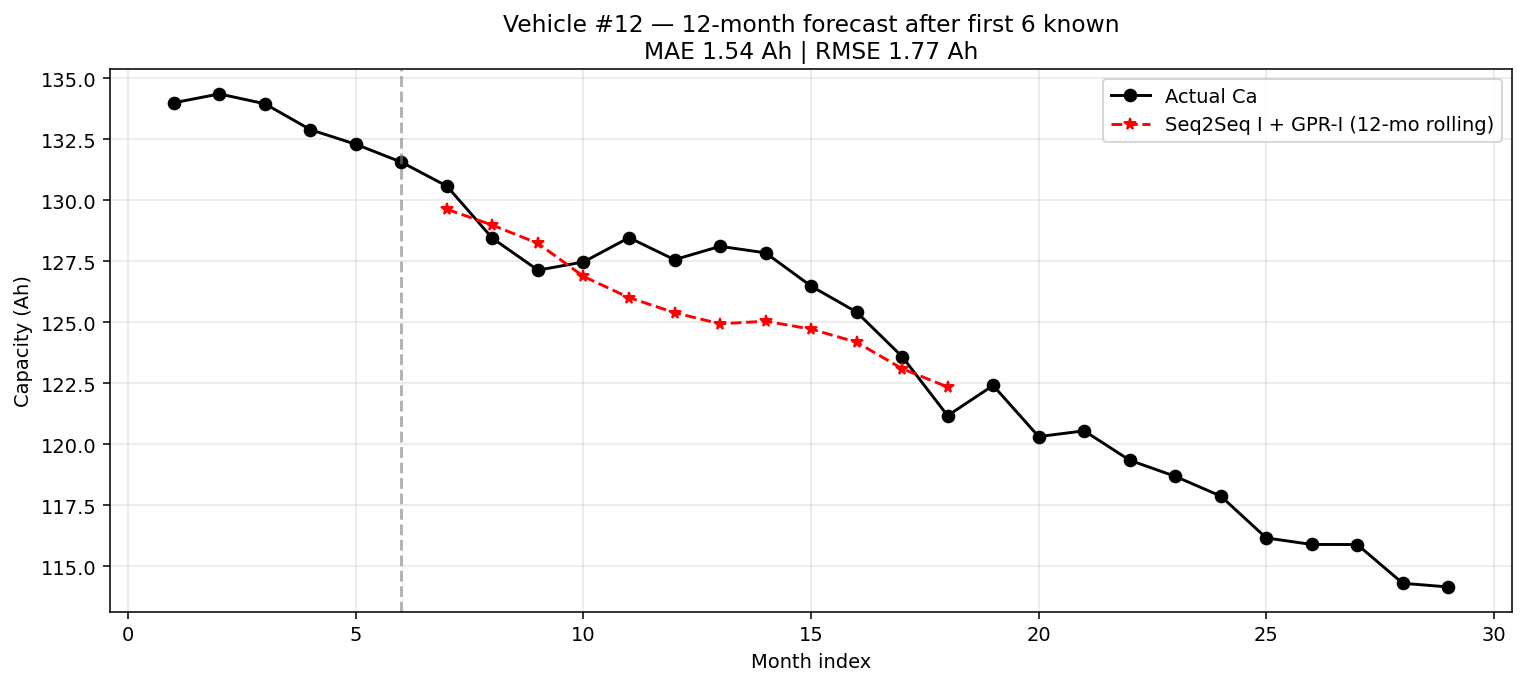


Saved:
artifacts/seq2seq1_f1.keras
artifacts/gpr_residual.pkl
artifacts/ca_scaler.pkl
artifacts/f_scaler.pkl
artifacts/x2_scaler.pkl
artifacts/features_f1.json


In [10]:
# === CLEAN RETRAIN: Seq2Seq I (BiLSTM, 1-step) + GPR-I residual, feature set F1 ===
# Trains with proper scaling (train-only), shows epochs, saves artifacts, and plots 12-month forecast.

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_absolute_error
import joblib, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ------------------------- Config -------------------------
N_KNOWN   = 6         # last 6 months known
H_FUTURE  = 12        # roll 12 months (1 year)
RND_SEED  = 7
TRAIN_IDS = list(range(1,11))       # vehicles 1..10
TEST_IDS  = list(range(11,21))      # vehicles 11..20
USE_FEATURES = [
    "I_ave","I_std","I_sum",
    "Vpack_ave","Vpack_std","Vpack_sum",
    "SOC_ave","SOC_std","SOC_sum",
    "Vmax_ave","Vmax_std","Vmax_sum",
    "Vmin_ave","Vmin_std","Vmin_sum",
    "Tmax_ave","Tmax_std","Tmax_sum",
    "Tmin_ave","Tmin_std","Tmin_sum",
    "Vd_ave","Vd_std","Vd_sum",
    "Td_ave","Td_std","Td_sum",
]
ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)
np.random.seed(RND_SEED); tf.random.set_seed(RND_SEED)

# ------------------------- Utilities -------------------------
def _rmse(a,b): 
    a=np.asarray(a); b=np.asarray(b); 
    return float(np.sqrt(np.mean((a-b)**2)))

def build_sequences(feat_df, ids):
    """Return dict per vehicle: sorted month, Ca, X1(features), and 1-step training samples."""
    seq = {}
    for vid in ids:
        dfv = feat_df.loc[feat_df["vehicle"]==vid].sort_values("month_ts")
        dfv = dfv.dropna(subset=["Ca"])  # ensure target exists
        c    = dfv["Ca"].values.astype(float)
        X1   = dfv[USE_FEATURES].values.astype(float)
        mvec = dfv["Month"].values.astype(int)  # 1..12

        # 1-step samples for training: use sliding windows of length N_KNOWN -> predict next Ca
        X_seq, y_next, x2_res = [], [], []
        for k in range(N_KNOWN, len(c)):
            X_seq.append(np.c_[c[k-N_KNOWN:k].reshape(-1,1), X1[k-N_KNOWN:k,:]])
            y_next.append(c[k])
            # inputs for residual model at time k (to predict error of next-month):
            x2_res.append([mvec[k], dfv["Tmax_ave"].iloc[k], dfv["Tmin_ave"].iloc[k]])

        seq[vid] = {
            "Month": mvec, "c": c, "X1": X1,
            "X_seq": np.asarray(X_seq),         # (samples, N_KNOWN, 1+F)
            "y_next": np.asarray(y_next),       # (samples,)
            "X2_res": np.asarray(x2_res, float) # (samples, 3)
        }
    return seq

# ------------------------- Data prep -------------------------
assert {"vehicle","month_ts","Month","Ca"}.issubset(feat_df.columns)
for col in USE_FEATURES: 
    if col not in feat_df.columns: raise ValueError(f"Missing feature {col}")

seq_train = build_sequences(feat_df, TRAIN_IDS)
seq_test  = build_sequences(feat_df, TEST_IDS)

# Stack train samples
X_train = np.concatenate([seq_train[i]["X_seq"] for i in TRAIN_IDS if len(seq_train[i]["X_seq"])>0], axis=0)
y_train = np.concatenate([seq_train[i]["y_next"] for i in TRAIN_IDS if len(seq_train[i]["y_next"])>0], axis=0)
X2_train= np.concatenate([seq_train[i]["X2_res"] for i in TRAIN_IDS if len(seq_train[i]["X2_res"])>0], axis=0)

# --- Fit scalers on TRAIN ONLY ---
# Separate scalers: one for Ca (first channel), one for feature block, and one for residual inputs.
ca_scaler  = StandardScaler().fit( X_train[:,:,0].reshape(-1,1) )
f_scaler   = StandardScaler().fit( X_train[:,:,1:].reshape(-1, X_train.shape[-1]-1) )
x2_scaler  = StandardScaler().fit( X2_train )

# Transform training windows
Xc  = ca_scaler.transform( X_train[:,:,0].reshape(-1,1) ).reshape(X_train.shape[0], X_train.shape[1], 1)
Xf  = f_scaler.transform( X_train[:,:,1:].reshape(-1, X_train.shape[-1]-1) ).reshape(X_train.shape[0], X_train.shape[1], -1)
X_train_s = np.concatenate([Xc, Xf], axis=2)
y_train_s = ca_scaler.transform( y_train.reshape(-1,1) ).ravel()

# ------------------------- Model -------------------------
def make_seq2seq(n_steps, n_feat, units=96, dropout=0.2):
    inp  = layers.Input(shape=(n_steps, n_feat))
    x    = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(inp)
    x    = layers.Dropout(dropout)(x)
    x    = layers.Bidirectional(layers.LSTM(units))(x)
    x    = layers.Dropout(dropout)(x)
    out  = layers.Dense(1)(x)  # predict 1-step-ahead Ca (scaled)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

model = make_seq2seq(N_KNOWN, 1+len(USE_FEATURES))

# Callbacks
cb = [
    keras.callbacks.ReduceLROnPlateau(patience=6, factor=0.5, min_lr=1e-5, verbose=1),
    keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
]

print(f"[Split] Train vehicles: {TRAIN_IDS}")
print(f"[Split] Test  vehicles: {TEST_IDS}")
print("\n[Seq2Seq] Training...")
hist = model.fit(
    X_train_s, y_train_s,
    validation_split=0.15, batch_size=256, epochs=120, verbose=2, callbacks=cb,
)

# ------------------------- Train GPR on residuals (train-only) -------------------------
# Build 1-step predictions on train samples to get residuals
yhat_train_s = model.predict(X_train_s, verbose=0).ravel()
residual_s   = (y_train_s - yhat_train_s)  # in scaled Ca space
ker = C(1.0, (1e-3, 1e3)) * RBF([1.0,1.0,1.0], (1e-2,1e2)) + WhiteKernel(1e-2, (1e-5, 1e0))
gpr = GaussianProcessRegressor(kernel=ker, alpha=1e-6, normalize_y=True, random_state=RND_SEED)
gpr.fit(x2_scaler.transform(X2_train), residual_s)

# ------------------------- Rolling 12-month forecast for one test vehicle -------------------------
def roll12_forecast(vid):
    d = seq_test[vid]
    assert len(d["c"]) >= N_KNOWN + H_FUTURE, "Not enough months for 12-month forecast."

    # seed window: last 6 known months (use the real Ca for the seed at deployment)
    c_win = d["c"][:N_KNOWN].copy()
    pred  = []
    for k in range(N_KNOWN, N_KNOWN + H_FUTURE):
        Xw = np.c_[ c_win[-N_KNOWN:].reshape(-1,1), d["X1"][k-N_KNOWN:k,:] ]
        Xcw = ca_scaler.transform(Xw[:,[0]]); Xfw = f_scaler.transform(Xw[:,1:])
        x_in = np.concatenate([Xcw, Xfw], axis=1)[None, ...]
        yhat_s = model.predict(x_in, verbose=0).ravel()[0]
        # residual correction with GPR-I for this month k
        x2 = np.array([[d["Month"][k], d["X1"][k, USE_FEATURES.index("Tmax_ave")-0], d["X1"][k, USE_FEATURES.index("Tmin_ave")-0]]], float)  # pull from X1 by name
        # safer: build from feat_df to ensure correct Tmax_ave/Tmin_ave at k
        # but we saved them into X1 too (same values)
        rhat_s = gpr.predict(x2_scaler.transform(x2))[0]
        y_next = ca_scaler.inverse_transform([[yhat_s + rhat_s]])[0,0]
        pred.append(y_next)
        c_win = np.r_[c_win, y_next]  # autoregressive roll

    t_all = np.arange(1, len(d["c"])+1)
    y_full = np.r_[ [np.nan]*N_KNOWN, np.array(pred), [np.nan]*(len(d["c"])-N_KNOWN-H_FUTURE) ]
    return t_all, d["c"], y_full

TEST_VEH_FOR_PLOT = 12  # change to any in TEST_IDS
t, y_true, y_pred12 = roll12_forecast(TEST_VEH_FOR_PLOT)

mask = ~np.isnan(y_pred12)
mae = mean_absolute_error(y_true[mask], y_pred12[mask])
rmse = _rmse(y_true[mask], y_pred12[mask])

plt.figure(figsize=(11,5), dpi=140)
plt.plot(t, y_true, "ko-", label="Actual Ca")
plt.plot(t[mask], y_pred12[mask], "r*--", label="Seq2Seq I + GPR-I (12-mo rolling)")
plt.axvline(N_KNOWN, ls="--", c="gray", alpha=0.6)
plt.title(f"Vehicle #{TEST_VEH_FOR_PLOT} — 12-month forecast after first 6 known\nMAE {mae:.2f} Ah | RMSE {rmse:.2f} Ah")
plt.xlabel("Month index"); plt.ylabel("Capacity (Ah)"); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# ------------------------- Save artifacts for Raspberry Pi -------------------------
model_path = os.path.join(ART_DIR, "seq2seq1_f1.keras")
gpr_path   = os.path.join(ART_DIR, "gpr_residual.pkl")
ca_s_path  = os.path.join(ART_DIR, "ca_scaler.pkl")
f_s_path   = os.path.join(ART_DIR, "f_scaler.pkl")
x2_s_path  = os.path.join(ART_DIR, "x2_scaler.pkl")
feat_path  = os.path.join(ART_DIR, "features_f1.json")

model.save(model_path)
joblib.dump(gpr,   gpr_path)
joblib.dump(ca_scaler, ca_s_path)
joblib.dump(f_scaler,  f_s_path)
joblib.dump(x2_scaler, x2_s_path)
json.dump({"USE_FEATURES": USE_FEATURES, "N_KNOWN": N_KNOWN}, open(feat_path,"w"))

print("\nSaved:")
print(model_path); print(gpr_path); print(ca_s_path); print(f_s_path); print(x2_s_path); print(feat_path)


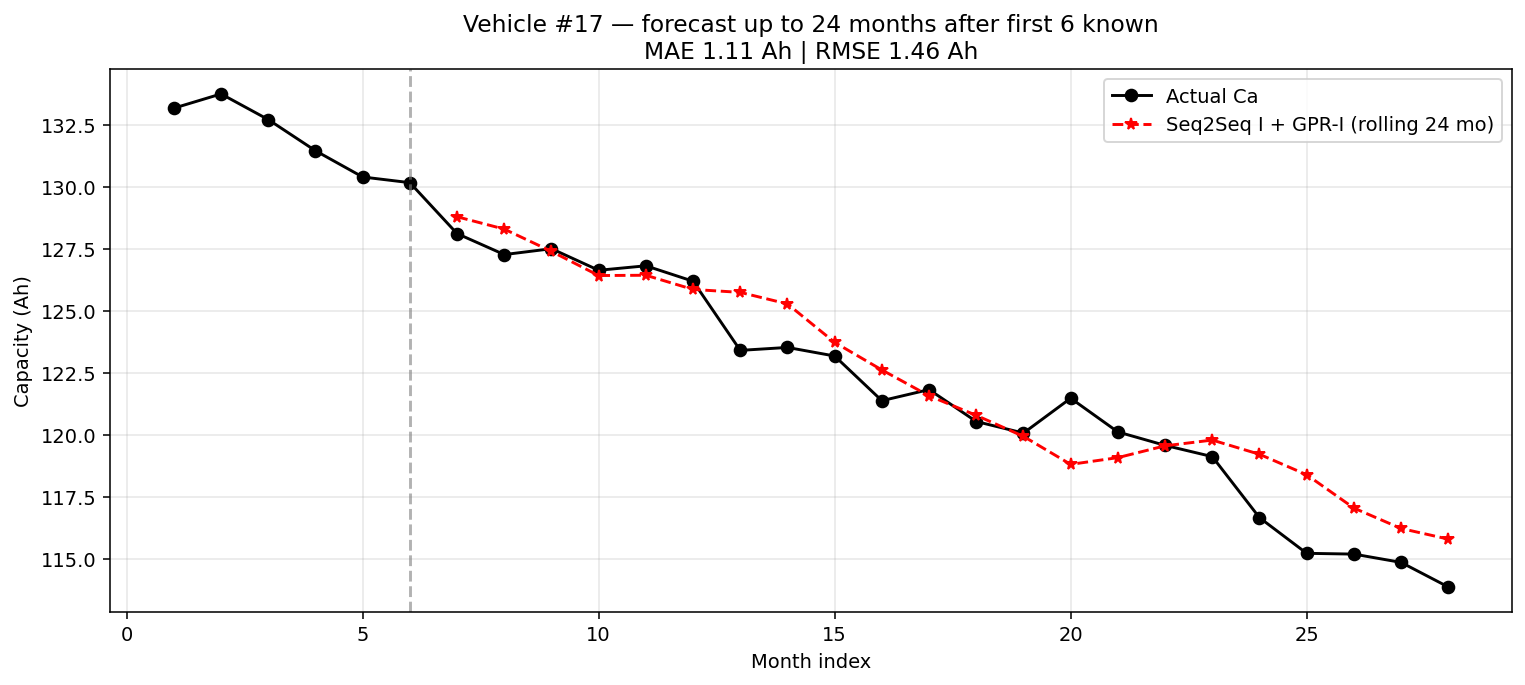

Saved: artifacts/veh17_rolling24m_preds.csv and artifacts/veh17_rolling24m_plot.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# === Use saved Seq2Seq-I + GPR-I to forecast VEHICLE 17 for up to 24 months ===
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import joblib, tensorflow as tf
from tensorflow import keras

ART_DIR = "artifacts"
MODEL_F = os.path.join(ART_DIR, "seq2seq1_f1.keras")
GPR_F   = os.path.join(ART_DIR, "gpr_residual.pkl")
CA_S_F  = os.path.join(ART_DIR, "ca_scaler.pkl")
F_S_F   = os.path.join(ART_DIR, "f_scaler.pkl")
X2_S_F  = os.path.join(ART_DIR, "x2_scaler.pkl")
CFG_F   = os.path.join(ART_DIR, "features_f1.json")

# --- Load artifacts
cfg        = json.load(open(CFG_F))
USE_FEATURES = cfg["USE_FEATURES"]
N_KNOWN      = int(cfg["N_KNOWN"])  # should be 6
seq2seq  = keras.models.load_model(MODEL_F)
gpr      = joblib.load(GPR_F)
ca_sc    = joblib.load(CA_S_F)
f_sc     = joblib.load(F_S_F)
x2_sc    = joblib.load(X2_S_F)

def _rmse(a,b): 
    a=np.asarray(a); b=np.asarray(b); 
    return float(np.sqrt(np.mean((a-b)**2)))

def build_vehicle_slice(feat_df, vid):
    dfv = feat_df.loc[feat_df["vehicle"]==vid].sort_values("month_ts").copy()
    dfv = dfv.dropna(subset=["Ca"])  # ensure target exists
    c    = dfv["Ca"].values.astype(float)
    X1   = dfv[USE_FEATURES].values.astype(float)
    mon  = dfv["Month"].values.astype(int)
    return dfv, c, X1, mon

def roll_forecast(feat_df, vid, max_h=24):
    dfv, c, X1, mon = build_vehicle_slice(feat_df, vid)
    assert len(c) >= N_KNOWN+1, "Need at least N_KNOWN+1 months in this vehicle."

    H = min(max_h, len(c) - N_KNOWN)
    c_win = c[:N_KNOWN].copy()
    pred = []

    for k in range(N_KNOWN, N_KNOWN + H):
        # compose the 6-step input window: [Ca, features] at each step
        W = np.c_[ c_win[-N_KNOWN:].reshape(-1,1), X1[k-N_KNOWN:k,:] ]
        Wc = ca_sc.transform(W[:,[0]])
        Wf = f_sc.transform(W[:,1:])
        x_in = np.concatenate([Wc, Wf], axis=1)[None, ...]
        yhat_s = seq2seq.predict(x_in, verbose=0).ravel()[0]

        # residual correction via GPR-I using Month, Tmax_ave, Tmin_ave at month k
        tmax = float(dfv["Tmax_ave"].iloc[k])
        tmin = float(dfv["Tmin_ave"].iloc[k])
        x2   = np.array([[mon[k], tmax, tmin]], float)
        rhat = gpr.predict(x2_sc.transform(x2))[0]

        y_next = ca_sc.inverse_transform([[yhat_s + rhat]])[0,0]
        pred.append(y_next)
        c_win = np.r_[c_win, y_next]

    # build aligned vectors for plotting
    t_all  = np.arange(1, len(c)+1)
    y_pred = np.full_like(c, np.nan, dtype=float)
    y_pred[N_KNOWN:N_KNOWN+H] = pred
    return t_all, c, y_pred, dfv

# Forecast and plot for Vehicle 17
VEH = 17
t, y_true, y_pred, dfv = roll_forecast(feat_df, VEH, max_h=24)

mask = ~np.isnan(y_pred)
mae  = mean_absolute_error(y_true[mask], y_pred[mask])
rmse = _rmse(y_true[mask], y_pred[mask])

plt.figure(figsize=(11,5), dpi=140)
plt.plot(t, y_true, "ko-", label="Actual Ca")
plt.plot(t[mask], y_pred[mask], "r*--", label="Seq2Seq I + GPR-I (rolling 24 mo)")
plt.axvline(N_KNOWN, ls="--", c="gray", alpha=0.6)
plt.title(f"Vehicle #{VEH} — forecast up to 24 months after first {N_KNOWN} known\nMAE {mae:.2f} Ah | RMSE {rmse:.2f} Ah")
plt.xlabel("Month index"); plt.ylabel("Capacity (Ah)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# Save artifacts for this run
out_csv = os.path.join(ART_DIR, f"veh{VEH}_rolling24m_preds.csv")
out_png = os.path.join(ART_DIR, f"veh{VEH}_rolling24m_plot.png")
pd.DataFrame({"month_idx": t, "actual_Ca": y_true, "pred_Ca": y_pred}).to_csv(out_csv, index=False)
plt.savefig(out_png, dpi=200)
print("Saved:", out_csv, "and", out_png)


In [ ]:
# Interactive forecast demo (SVR / GPR / Seq2Seq-I + GPR-I) using in-memory feat_df 
# This works only if feat_df is run once the 20-vehicle file instead use the next code bloack that refers to feat-df csv file, instead of using global?in memory dataframe it used csv file
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR as _SVR
from sklearn.gaussian_process import GaussianProcessRegressor as _GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import joblib

# Widgets
import ipywidgets as W
from IPython.display import display, clear_output

# ---- Validate that feat_df is already present in memory (as you requested) ----
if "feat_df" not in globals():
    raise RuntimeError("feat_df is not defined in memory. Run your 'ALL 20 VEHICLES …' cell first.")

# ---- Small helpers ----
def _rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def _load_cfg_and_artifacts():
    art = "artifacts"
    cfg_path = os.path.join(art, "features_f1.json")
    with open(cfg_path, "r") as f:
        cfg = json.load(f)
    USE_FEATURES = cfg["USE_FEATURES"]
    N_KNOWN_DEF  = int(cfg.get("N_KNOWN", 6))

    # Seq2Seq + residual GPR artifacts
    paths = {
        "seq2seq": os.path.join(art, "seq2seq1_f1.keras"),
        "gpr_res" : os.path.join(art, "gpr_residual.pkl"),
        "ca_sc"   : os.path.join(art, "ca_scaler.pkl"),
        "f_sc"    : os.path.join(art, "f_scaler.pkl"),
        "x2_sc"   : os.path.join(art, "x2_scaler.pkl"),
    }
    return USE_FEATURES, N_KNOWN_DEF, paths

def _build_vehicle_slice(df, vid, use_features):
    d = df.loc[df["vehicle"] == vid].sort_values("month_ts").dropna(subset=["Ca"]).copy()
    c   = d["Ca"].values.astype(float)
    X   = d[use_features].values.astype(float)
    mon = d["Month"].astype(int).values
    return d, c, X, mon

# ---------- Seq2Seq-I + GPR-I rolling forecast ----------
def _forecast_seq2seq_gpr(df, vehicle, n_known, max_h, use_features, paths):
    # Lazy import TF/Keras only if needed
    import tensorflow as tf
    from tensorflow import keras

    # load models/scalers
    seq2seq = keras.models.load_model(paths["seq2seq"])
    gpr_res = joblib.load(paths["gpr_res"])
    ca_sc   = joblib.load(paths["ca_sc"])
    f_sc    = joblib.load(paths["f_sc"])
    x2_sc   = joblib.load(paths["x2_sc"])

    d, c, X, mon = _build_vehicle_slice(df, vehicle, use_features)
    if len(c) <= n_known:
        raise ValueError(f"Vehicle {vehicle}: not enough months ({len(c)}) for n_known={n_known}.")

    H = min(max_h, len(c) - n_known)
    c_win = c[:n_known].copy()
    pred = []

    for k in range(n_known, n_known + H):
        # window [n_known x (1 + len(features))]
        W  = np.c_[ c_win[-n_known:].reshape(-1, 1), X[k - n_known:k, :] ]
        Wc = ca_sc.transform(W[:, [0]])
        Wf = f_sc.transform(W[:, 1:])
        x_in = np.concatenate([Wc, Wf], axis=1)[None, ...]
        yhat_s = seq2seq.predict(x_in, verbose=0).ravel()[0]

        # residual correction uses [Month, Tmax_ave, Tmin_ave] at step k
        tmax = float(d["Tmax_ave"].iloc[k])
        tmin = float(d["Tmin_ave"].iloc[k])
        x2   = np.array([[mon[k], tmax, tmin]], float)
        rhat = gpr_res.predict(x2_sc.transform(x2))[0]

        y_next = ca_sc.inverse_transform([[yhat_s + rhat]])[0, 0]
        pred.append(y_next)
        c_win = np.r_[c_win, y_next]

    t_all  = np.arange(1, len(c) + 1)
    y_pred = np.full_like(c, np.nan, dtype=float)
    y_pred[n_known:n_known + H] = pred
    return t_all, c, y_pred

# ---------- Static estimators (SVR / GPR) ----------
# If artifacts missing, quick-train on lowest 10 vehicles (demo speed)
def _get_or_train_static(model_name, df, use_features, save_path):
    # Try to load
    if os.path.exists(save_path):
        return joblib.load(save_path)

    # quick train (demo) — train on vehicles with the lowest 10 IDs
    vids = sorted(df["vehicle"].unique())[:10]
    train = df[df["vehicle"].isin(vids)].dropna(subset=["Ca"]).copy()

    X = train[use_features].values.astype(float)
    y = train["Ca"].values.astype(float)

    if model_name == "svr":
        model = _SVR(C=10.0, epsilon=0.2, kernel="rbf", gamma="scale")
    elif model_name == "gpr":
        # small GPR kernel for speed
        kernel = RBF(length_scale=5.0) + WhiteKernel(noise_level=1.0)
        model  = _GPR(kernel=kernel, normalize_y=True, random_state=0)
    else:
        raise ValueError("model_name must be 'svr' or 'gpr'")

    # standardize inputs
    xsc = StandardScaler().fit(X)
    Xs  = xsc.transform(X)
    model.fit(Xs, y)

    joblib.dump({"model": model, "xsc": xsc}, save_path)
    return {"model": model, "xsc": xsc}

def _predict_static_curve(df, vehicle, n_known, max_h, use_features, bundle):
    d, c, X, _ = _build_vehicle_slice(df, vehicle, use_features)
    if len(c) <= n_known:
        raise ValueError(f"Vehicle {vehicle}: not enough months ({len(c)}) for n_known={n_known}.")

    H = min(max_h, len(c) - n_known)
    model = bundle["model"]; xsc = bundle["xsc"]

    # For months after n_known, we "predict Ca from the same-month features".
    # (This is an estimation demo; true forecasting would need future features.)
    idx  = np.arange(n_known, n_known + H)
    Xf   = X[idx, :]
    yhat = model.predict(xsc.transform(Xf))

    t_all  = np.arange(1, len(c) + 1)
    y_pred = np.full_like(c, np.nan, dtype=float)
    y_pred[idx] = yhat
    return t_all, c, y_pred

# ---- UI widgets ----
use_features, N_KNOWN_DEF, art_paths = _load_cfg_and_artifacts()
veh_sorted  = sorted(int(v) for v in feat_df["vehicle"].unique())
veh_min, veh_max = min(veh_sorted), max(veh_sorted)

model_dd   = W.Dropdown(options=[("Seq2Seq+GPR (paper)", "seq2seq_gpr"),
                                 ("GPR (baseline)", "gpr"),
                                 ("SVR (baseline)", "svr")],
                        value="seq2seq_gpr", description="Model:")
veh_slider = W.IntSlider(value=veh_sorted[0], min=veh_min, max=veh_max, step=1, description="Vehicle:", readout=True)
known_sl   = W.IntSlider(value=N_KNOWN_DEF, min=3, max=12, step=1, description="Known Mo.:")
h_sl       = W.IntSlider(value=12, min=3, max=24, step=1, description="Forecast Mo.:")
run_btn    = W.Button(description="Run Forecast", button_style="success")

out = W.Output()

def _plot_series(t, y_true, y_pred, n_known, title_prefix):
    mask = ~np.isnan(y_pred)
    mae  = mean_absolute_error(y_true[mask], y_pred[mask]) if mask.any() else np.nan
    rmse = _rmse(y_true[mask], y_pred[mask]) if mask.any() else np.nan

    plt.figure(figsize=(10.5, 4.5), dpi=140)
    plt.plot(t, y_true, "ko-", label="Actual Ca", ms=4)
    if mask.any():
        plt.plot(t[mask], y_pred[mask], "r*--", label="Predicted", ms=6)
    plt.axvline(n_known, ls="--", c="gray", alpha=0.6)
    ttl = f"{title_prefix}  |  MAE {mae:.2f} Ah, RMSE {rmse:.2f} Ah" if mask.any() else f"{title_prefix}  |  (no forecast window)"
    plt.title(ttl)
    plt.xlabel("Month index"); plt.ylabel("Capacity (Ah)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

@out.capture(clear_output=True, wait=True)
def on_run_clicked(b):
    model   = model_dd.value
    vehicle = int(veh_slider.value)
    known   = int(known_sl.value)
    horizon = int(h_sl.value)

    print(f"Running {model} for vehicle {vehicle} with {known} months known, forecasting {horizon} months...\n")

    try:
        if model == "seq2seq_gpr":
            t, y_true, y_pred = _forecast_seq2seq_gpr(feat_df, vehicle, known, horizon, use_features, art_paths)
            _plot_series(t, y_true, y_pred, known, f"Vehicle #{vehicle} — Seq2Seq-I + GPR-I")

        elif model in ("svr", "gpr"):
            # try to load (or quick-train) a static baseline
            save_path = os.path.join("artifacts", f"{model}.pkl")
            bundle = _get_or_train_static(model, feat_df, use_features, save_path)
            t, y_true, y_pred = _predict_static_curve(feat_df, vehicle, known, horizon, use_features, bundle)
            _plot_series(t, y_true, y_pred, known, f"Vehicle #{vehicle} — {model.upper()} (estimation demo)")

        else:
            print("Unknown model key.")
    except Exception as e:
        print("Error:", e)

run_btn.on_click(on_run_clicked)

ui = W.VBox([
    W.HBox([model_dd, veh_slider]),
    W.HBox([known_sl, h_sl, run_btn]),
    out
])

display(ui)
print("Available models:", [opt[1] for opt in model_dd.options])


Available models: ['seq2seq_gpr', 'gpr', 'svr']


In [ ]:
# === Interactive forecast demo (SVR / GPR / Seq2Seq-I + GPR-I) using CSV-backed feat_df ===
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR as _SVR
from sklearn.gaussian_process import GaussianProcessRegressor as _GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import joblib

# Widgets
import ipywidgets as W
from IPython.display import display, clear_output

CSV_PATH = os.path.join("artifacts", "feat_df_all_vehicles.csv")

def load_feat_df(path=CSV_PATH) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Could not find {path}. Re-run the feature-extraction cell to create it."
        )
    df = pd.read_csv(path, parse_dates=["month_ts"])
    # ensure numeric dtypes for all feature columns except id/time fields
    non_num = {"vehicle", "Month", "month_ts"}
    num_cols = [c for c in df.columns if c not in non_num]
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
    # sort & clean
    df = df.sort_values(["vehicle", "month_ts"]).drop_duplicates(["vehicle", "month_ts"])
    return df

feat_df = load_feat_df()

# ---- Small helpers ----
def _rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def _load_cfg_and_artifacts():
    art = "artifacts"
    cfg_path = os.path.join(art, "features_f1.json")
    with open(cfg_path, "r") as f:
        cfg = json.load(f)
    USE_FEATURES = cfg["USE_FEATURES"]
    N_KNOWN_DEF  = int(cfg.get("N_KNOWN", 6))

    # Seq2Seq + residual GPR artifacts
    paths = {
        "seq2seq": os.path.join(art, "seq2seq1_f1.keras"),
        "gpr_res" : os.path.join(art, "gpr_residual.pkl"),
        "ca_sc"   : os.path.join(art, "ca_scaler.pkl"),
        "f_sc"    : os.path.join(art, "f_scaler.pkl"),
        "x2_sc"   : os.path.join(art, "x2_scaler.pkl"),
    }
    # quick sanity: all required columns present?
    needed_cols = {"Tmax_ave","Tmin_ave"}
    missing = [c for c in needed_cols if c not in feat_df.columns]
    if missing:
        raise RuntimeError(f"feat_df is missing columns needed by residual GPR: {missing}")
    return USE_FEATURES, N_KNOWN_DEF, paths

def _build_vehicle_slice(df, vid, use_features):
    d = df.loc[df["vehicle"] == vid].sort_values("month_ts").dropna(subset=["Ca"]).copy()
    if d.empty:
        raise ValueError(f"No rows found for vehicle {vid}.")
    # ensure all needed features exist
    miss = [c for c in use_features if c not in d.columns]
    if miss:
        raise RuntimeError(f"Missing features in feat_df for this run: {miss}")
    c   = d["Ca"].values.astype(float)
    X   = d[use_features].values.astype(float)
    mon = d["Month"].astype(int).values
    return d, c, X, mon

# ---------- Seq2Seq-I + GPR-I rolling forecast ----------
def _forecast_seq2seq_gpr(df, vehicle, n_known, max_h, use_features, paths):
    import tensorflow as tf
    from tensorflow import keras

    seq2seq = keras.models.load_model(paths["seq2seq"])
    gpr_res = joblib.load(paths["gpr_res"])
    ca_sc   = joblib.load(paths["ca_sc"])
    f_sc    = joblib.load(paths["f_sc"])
    x2_sc   = joblib.load(paths["x2_sc"])

    d, c, X, mon = _build_vehicle_slice(df, vehicle, use_features)
    if len(c) <= n_known:
        raise ValueError(f"Vehicle {vehicle}: not enough months ({len(c)}) for n_known={n_known}.")

    H = min(max_h, len(c) - n_known)
    c_win = c[:n_known].copy()
    pred = []

    for k in range(n_known, n_known + H):
        W  = np.c_[ c_win[-n_known:].reshape(-1, 1), X[k - n_known:k, :] ]
        Wc = ca_sc.transform(W[:, [0]])
        Wf = f_sc.transform(W[:, 1:])
        x_in = np.concatenate([Wc, Wf], axis=1)[None, ...]
        yhat_s = seq2seq.predict(x_in, verbose=0).ravel()[0]

        # residual correction uses [Month, Tmax_ave, Tmin_ave] at step k
        tmax = float(d["Tmax_ave"].iloc[k])
        tmin = float(d["Tmin_ave"].iloc[k])
        x2   = np.array([[mon[k], tmax, tmin]], float)
        rhat = gpr_res.predict(x2_sc.transform(x2))[0]

        y_next = ca_sc.inverse_transform([[yhat_s + rhat]])[0, 0]
        pred.append(y_next)
        c_win = np.r_[c_win, y_next]

    t_all  = np.arange(1, len(c) + 1)
    y_pred = np.full_like(c, np.nan, dtype=float)
    y_pred[n_known:n_known + H] = pred
    return t_all, c, y_pred

# ---------- Static estimators (SVR / GPR) ----------
def _get_or_train_static(model_name, df, use_features, save_path):
    if os.path.exists(save_path):
        return joblib.load(save_path)

    vids = sorted(df["vehicle"].unique())[:10]
    train = df[df["vehicle"].isin(vids)].dropna(subset=["Ca"]).copy()
    X = train[use_features].values.astype(float)
    y = train["Ca"].values.astype(float)

    if model_name == "svr":
        model = _SVR(C=10.0, epsilon=0.2, kernel="rbf", gamma="scale")
    elif model_name == "gpr":
        kernel = RBF(length_scale=5.0) + WhiteKernel(noise_level=1.0)
        model  = _GPR(kernel=kernel, normalize_y=True, random_state=0)
    else:
        raise ValueError("model_name must be 'svr' or 'gpr'")

    xsc = StandardScaler().fit(X)
    Xs  = xsc.transform(X)
    model.fit(Xs, y)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump({"model": model, "xsc": xsc}, save_path)
    return {"model": model, "xsc": xsc}

def _predict_static_curve(df, vehicle, n_known, max_h, use_features, bundle):
    d, c, X, _ = _build_vehicle_slice(df, vehicle, use_features)
    if len(c) <= n_known:
        raise ValueError(f"Vehicle {vehicle}: not enough months ({len(c)}) for n_known={n_known}.")
    H = min(max_h, len(c) - n_known)
    model = bundle["model"]; xsc = bundle["xsc"]
    idx  = np.arange(n_known, n_known + H)
    Xf   = X[idx, :]
    yhat = model.predict(xsc.transform(Xf))
    t_all  = np.arange(1, len(c) + 1)
    y_pred = np.full_like(c, np.nan, dtype=float)
    y_pred[idx] = yhat
    return t_all, c, y_pred

# ---- UI widgets ----
use_features, N_KNOWN_DEF, art_paths = _load_cfg_and_artifacts()
veh_sorted  = sorted(int(v) for v in feat_df["vehicle"].unique())
veh_min, veh_max = min(veh_sorted), max(veh_sorted)

model_dd   = W.Dropdown(options=[("Seq2Seq+GPR (paper)", "seq2seq_gpr"),
                                 ("GPR (baseline)", "gpr"),
                                 ("SVR (baseline)", "svr")],
                        value="seq2seq_gpr", description="Model:")
veh_slider = W.IntSlider(value=veh_sorted[0], min=veh_min, max=veh_max, step=1,
                         description="Vehicle:", readout=True, continuous_update=False)
known_sl   = W.IntSlider(value=N_KNOWN_DEF, min=3, max=12, step=1,
                         description="Known Mo.:", continuous_update=False)
h_sl       = W.IntSlider(value=12, min=3, max=24, step=1,
                         description="Forecast Mo.:", continuous_update=False)
run_btn    = W.Button(description="Run Forecast", button_style="success")
out = W.Output()

def _plot_series(t, y_true, y_pred, n_known, title_prefix):
    mask = ~np.isnan(y_pred)
    mae  = mean_absolute_error(y_true[mask], y_pred[mask]) if mask.any() else np.nan
    rmse = _rmse(y_true[mask], y_pred[mask]) if mask.any() else np.nan
    plt.figure(figsize=(10.5, 4.5), dpi=140)
    plt.plot(t, y_true, "ko-", label="Actual Ca", ms=4)
    if mask.any():
        plt.plot(t[mask], y_pred[mask], "r*--", label="Predicted", ms=6)
    plt.axvline(n_known, ls="--", c="gray", alpha=0.6)
    ttl = (f"{title_prefix}  |  MAE {mae:.2f} Ah, RMSE {rmse:.2f} Ah"
           if mask.any() else f"{title_prefix}  |  (no forecast window)")
    plt.title(ttl); plt.xlabel("Month index"); plt.ylabel("Capacity (Ah)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

@out.capture(clear_output=True, wait=True)
def on_run_clicked(b):
    model   = model_dd.value
    vehicle = int(veh_slider.value)
    known   = int(known_sl.value)
    horizon = int(h_sl.value)

    print(f"Running {model} for vehicle {vehicle} with {known} months known, forecasting {horizon} months...\n")
    try:
        if model == "seq2seq_gpr":
            t, y_true, y_pred = _forecast_seq2seq_gpr(feat_df, vehicle, known, horizon, use_features, art_paths)
            _plot_series(t, y_true, y_pred, known, f"Vehicle #{vehicle} — Seq2Seq-I + GPR-I")
        elif model in ("svr", "gpr"):
            save_path = os.path.join("artifacts", f"{model}.pkl")
            bundle = _get_or_train_static(model, feat_df, use_features, save_path)
            t, y_true, y_pred = _predict_static_curve(feat_df, vehicle, known, horizon, use_features, bundle)
            _plot_series(t, y_true, y_pred, known, f"Vehicle #{vehicle} — {model.upper()} (estimation demo)")
        else:
            print("Unknown model key.")
    except Exception as e:
        print("Error:", e)

run_btn.on_click(on_run_clicked)

ui = W.VBox([
    W.HBox([model_dd, veh_slider]),
    W.HBox([known_sl, h_sl, run_btn]),
    out
])

display(ui)
print("Available models:", [opt[1] for opt in model_dd.options])


Available models: ['seq2seq_gpr', 'gpr', 'svr']
